# Node Classification with Graph Neural Networks


## Information embedded in data

Many datasets in various machine learning (ML) applications have structural relationships
between their entities, which can be represented as graphs. Such application includes
social and communication networks analysis, traffic prediction, and fraud detection.
Graph representation Learning
aims to build and train models for graph datasets to be used for a variety of machine learning tasks.

In machine learning we build models using the information contained in a collection of samples.

We can look at the information embedded in data as a combination of:
- The **signal**, encoding the features of the variables.
- The **structure**, encoding the relations between variables.



![alt text](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/09/pics/data-signal-domain.PNG) 



Sometimes most of the information is in the signal.


Sometimes most of the information is in the structure.

To learn proper models, we should be able to grasp all the relevant information in our data, whether in the signal or in the structure.

Notice that often the mutual information between the signal and the structure is non-zero, i.e. you may obtain some information about the signal observing only the structure and viceversa. Nevertheless it may be much easier to extract the information from one of the two.

# Decomposing features (signal) and structure

As we saw in RNNs and Transformers, natural language can also be decomposed to signal and structure. The structure is the order of words, which implies syntax and grammar context. Here is an illustrative example:

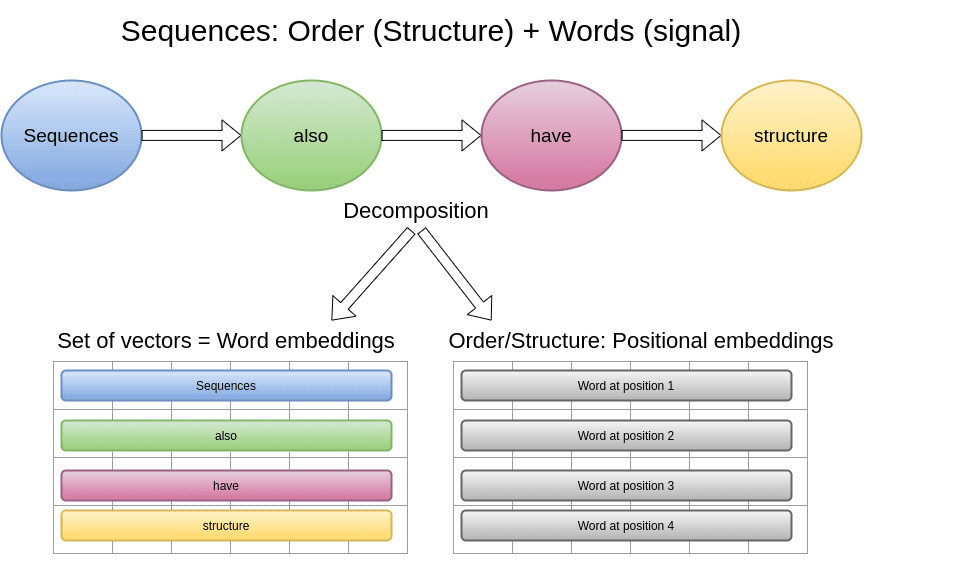

The features will now be a set of word embeddings and the order will be encoded in the positional embeddings.

Graphs are not any different: they are data with decomposed structure and signal information.

Real-world signals that we can model with graphs.

As long as you can define these two representations, you can model anything you want with graphs. Formally, the words or pixels are simply nodes, denoted by N. The connectivity/structure will be defined by a N×N matrix, the so-called Adjacency matrix A. The element i,j of A will tell us if node i is connected to node j.

The signal for each node will be X (N×F) , where F is the number of features. 


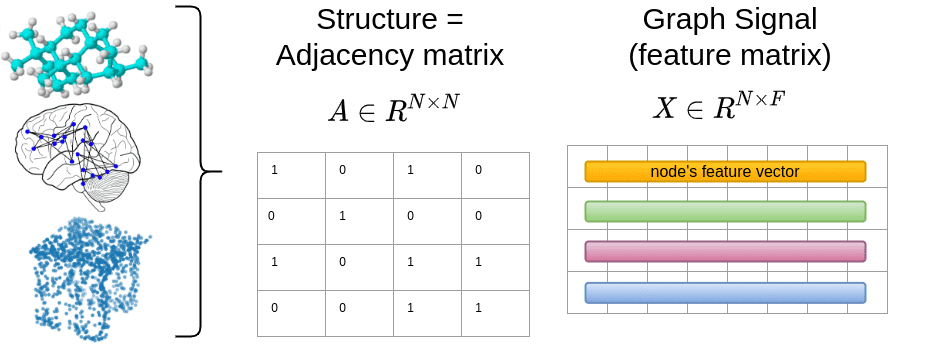

In [ ]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 36.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import networkx as nx
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [ ]:
dataset = dgl.data.CoraGraphDataset()
print("Number of categories:", dataset.num_classes)

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


In [ ]:
g = dataset[0]
num_class = dataset.num_classes
# get node feature
feat = g.ndata['feat']
# get data split
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
# get labels
label = g.ndata['label']
# get nodes
node = g.nodes()

###Let's import the graph to networkx and plot it

In [ ]:
nx_g = dgl.to_networkx(g)

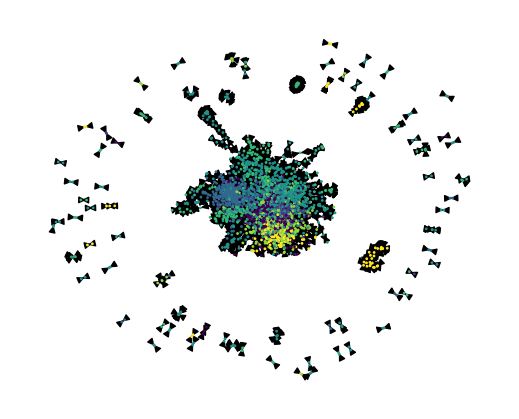

In [ ]:
plt.figure(figsize=[5,4])
nx.draw_spring(nx_g, node_size=1, node_color=label)

node2vec embeddings

## The Node2Vec algorithm

The Node2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are,

1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [2], is used for calculating the embedding vectors.


## Corpus generation using random walks

We use a dgl implementation for second-order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`.

In [ ]:
#p (float) – Likelihood of immediately revisiting a node in the walk.
#q (float) – Control parameter to interpolate between breadth-first strategy and depth-first strategy.
#walk_length (int) – Length of random walks.

walks = dgl.sampling.node2vec_random_walk(g,g.nodes(), p=1, q=1, walk_length=100)

## Representation Learning using Word2Vec

We use the `Word2Vec`, implementation in the free Python library `Gensim`, to learn representations for each node in the graph.
We set the dimensionality of the learned embedding vectors to 16.

In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks.tolist()]
model = Word2Vec(str_walks, vector_size =16, window=7, min_count=0, sg=1)

In [ ]:
#string_walks is analogous to word sentences for word2vec
print(str_walks[0])
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv['1866'].shape

['0', '1862', '926', '1862', '0', '1862', '926', '1862', '926', '1862', '0', '2582', '1166', '2582', '1166', '1986', '1997', '2412', '1997', '2412', '197', '231', '1701', '318', '2045', '126', '236', '1572', '1776', '2045', '699', '1701', '1874', '722', '1567', '1654', '1567', '2500', '1567', '1874', '2500', '1874', '722', '2501', '722', '1273', '1111', '1119', '1663', '1119', '2124', '1608', '2489', '1608', '2489', '1608', '546', '1608', '546', '1608', '2489', '1608', '2126', '2124', '1119', '1111', '2125', '2124', '1611', '1462', '1663', '1462', '1119', '870', '577', '1063', '1518', '1063', '1518', '1063', '577', '870', '2126', '1608', '2124', '2125', '1273', '1111', '1273', '1119', '2125', '1273', '2034', '1983', '55', '815', '55', '323', '55', '1156', '55']


(16,)

## Visualize Node Embeddings

We retrieve the `Word2Vec` node embeddings that are 16-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [ ]:
node_embeddings = []
for i in range(len(node)):
  node_embeddings.append(model.wv[str(i)])
node_embeddings = np.array(node_embeddings)

In [ ]:
# Apply t-SNE transformation on node embeddings

tsne = TSNE(n_components=2, learning_rate='auto',init='random')
node_embeddings_2d = tsne.fit_transform(node_embeddings)

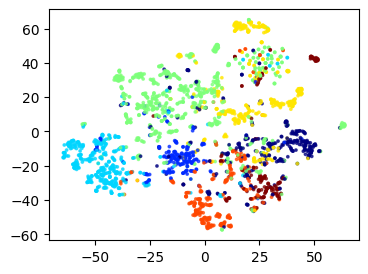

In [ ]:
alpha = 0.7
#label_map = {l: i for i, l in enumerate(np.unique(label))}
#node_colours = [label_map[target] for target in label]

plt.figure(figsize=(4,3))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=label.tolist(),
    cmap="jet",
    s = 3,
    alpha=alpha,
)

#Training a classifier
The node2vec embeddings are from the point of view of machine learning just ordinary feature vectors. Taking a training and test set really means in this case taking a subset of the nodes (a subgraph) even though on a code level it’s just an ordinary classifier.

In [ ]:
clf = LogisticRegression(random_state=0)
X = node_embeddings
Y = np.array(label)
X_train = X[train_mask]
X_test = X[test_mask]
y_train = Y[train_mask]
y_test = Y[test_mask]
clf.fit(X_train, y_train)

print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.8928571428571429
score on X_test 0.669


## USING GRAPH NEURAL NETWORKS FOR NODE PREDICTIONS
UNTIL NOW WE USED ONLY **STRUCUTRE** (shallow embeddings) NOW WE'LL USE ALSO THE **FEATURES**

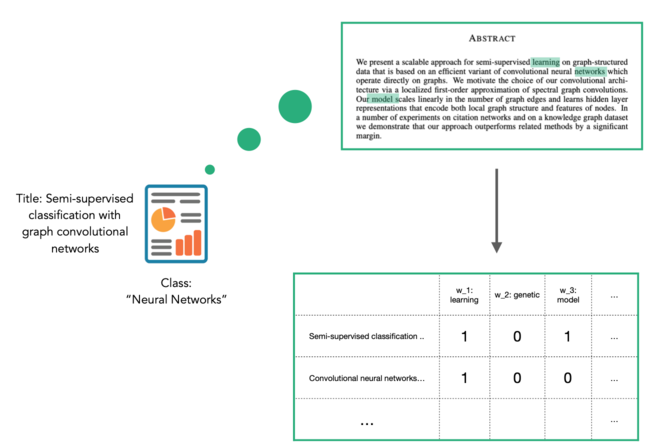

The CORA dataset contains attributes `w_x` that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero. These numeric attributes have been automatically included in the `StellarGraph` instance `G`, and so we do not have to do any further conversion.

## 3. Training and evaluating

### Training the model

In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats) #embedding size: from 1433 to 16
        self.conv2 = GraphConv(h_feats, num_classes) #embedding size: from 16 to 7

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 1.945, val acc: 0.172 (best 0.172), test acc: 0.136 (best 0.136)
In epoch 5, loss: 1.892, val acc: 0.564 (best 0.564), test acc: 0.547 (best 0.547)
In epoch 10, loss: 1.809, val acc: 0.642 (best 0.656), test acc: 0.664 (best 0.667)
In epoch 15, loss: 1.704, val acc: 0.662 (best 0.662), test acc: 0.658 (best 0.658)
In epoch 20, loss: 1.572, val acc: 0.710 (best 0.710), test acc: 0.716 (best 0.716)
In epoch 25, loss: 1.419, val acc: 0.744 (best 0.744), test acc: 0.732 (best 0.731)
In epoch 30, loss: 1.250, val acc: 0.744 (best 0.746), test acc: 0.743 (best 0.731)
In epoch 35, loss: 1.072, val acc: 0.758 (best 0.758), test acc: 0.745 (best 0.745)
In epoch 40, loss: 0.897, val acc: 0.764 (best 0.764), test acc: 0.755 (best 0.755)
In epoch 45, loss: 0.736, val acc: 0.770 (best 0.770), test acc: 0.756 (best 0.755)
In epoch 50, loss: 0.594, val acc: 0.770 (best 0.770), test acc: 0.762 (best 0.755)
In epoch 55, loss: 0.476, val acc: 0.774 (best 0.774), test acc: 0.765 (best 0

###Note that accuracy is much better than using only node2vec embeddings as features

### Node embeddings

In addition to just predicting the node class, it can be useful to get a more detailed picture of what information the model has learnt about the nodes and their neighbourhoods. In this case, this means an embedding of the node into a latent vector space that captures that information, and it comes in the form of either a look-up table mapping node to a vector of numbers (like node2vec), or a neural network that produces those vectors. For GCN, we're going to be using the second option, using the last graph convolution layer of the GCN model (called `x_out` above), before we applied the prediction layer.

We can visualise these embeddings as points on a plot, colored by their true subject labels. If the model has learned useful information about the nodes based on their class, we expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

These tensors are connected to the same layers and weights that we trained when training the predictions above, and so we're only using this model to compute/"predict" the node embedding vectors.

In [ ]:
model

GCN(
  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=7, normalization=both, activation=None)
)

###We'll take the first GC layer embeddings for plotting; the last one is ready for the softmax

In [ ]:
GCN_embeddings = model.eval().conv1.forward(g,g.ndata['feat']).detach().numpy()

In [ ]:
GCN_embeddings.shape

(2708, 16)

In [ ]:
# Apply t-SNE transformation on node embeddings

tsne = TSNE(n_components=2, learning_rate='auto',init='random')
node_embeddings_2d = tsne.fit_transform(GCN_embeddings)

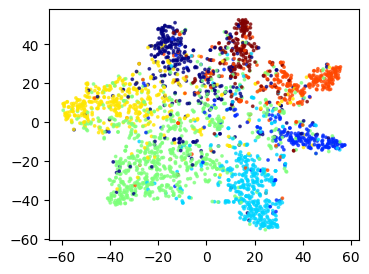

In [ ]:
# draw the points

alpha = 0.7
#label_map = {l: i for i, l in enumerate(np.unique(label))}
#node_colours = [label_map[target] for target in label]

plt.figure(figsize=(4,3))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=label.tolist(),
    cmap="jet",
    s = 3,
    alpha=alpha,
)

Note GCN embeddings are better ML features than the node2vec embeddings, and results are not far from the end-to-end GCN classification performance

In [ ]:
clf = LogisticRegression(random_state=0)
X = GCN_embeddings
Y = np.array(label)
X_train = X[train_mask]
X_test = X[test_mask]
y_train = Y[train_mask]
y_test = Y[test_mask]
clf.fit(X_train, y_train)

print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.8571428571428571
score on X_test 0.715


### If we use only the features without the structure

Let's use only the node's features (the text) for the predictions

Accuracy is around 50% but recall that we have seven classes

In [ ]:
clf = LogisticRegression(random_state=0)
X = g.ndata['feat']
Y = np.array(label)
X_train = X[train_mask]
X_test = X[test_mask]
y_train = Y[train_mask]
y_test = Y[test_mask]
clf.fit(X_train, y_train)

print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.9857142857142858
score on X_test 0.575


####Visualization

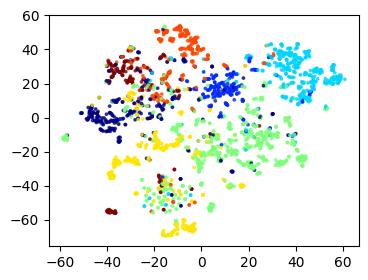

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto',init='random')

feat_2d = tsne.fit_transform(X)

plt.figure(figsize=(4,3))
plt.scatter(
    feat_2d[:, 0],
    feat_2d[:, 1],
    c=label.tolist(),
    cmap="jet",
    s = 3,
    alpha=alpha,
)

# Early and late fusion of signal and structure information

Now let's append the text features (signal) to the node2vec embeddings (structure)

In [ ]:
clf = LogisticRegression(random_state=0)
X = np.hstack((node_embeddings,g.ndata['feat']))
Y = np.array(label)
X_train = X[train_mask]
X_test = X[test_mask]
y_train = Y[train_mask]
y_test = Y[test_mask]
clf.fit(X_train, y_train)

print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.9071428571428571
score on X_test 0.67


Performance improved but it's quite similar to using structure only (node2vec embeddings) and certainly worse than the Graph Neural Network which fuses structure and signal from the beggining

#PART II

# Implementation of Simplified Graph Convolutions (SGC) as a logistic regression on the diffused node embeddings
---



# Node classification with Simplified Graph Convolutions (SGC)

from 
[Simplifying approach to Node Classification in Graph Neural Networks](https://arxiv.org/pdf/2111.06748.pdf)

see also [Simple scalable graph neural networks](https://blog.twitter.com/engineering/en_us/topics/insights/2021/simple-scalable-graph-neural-networks)




#[Computational Representations of Message Passing](https://ericmjl.github.io/essays-on-data-science/machine-learning/message-passing/)



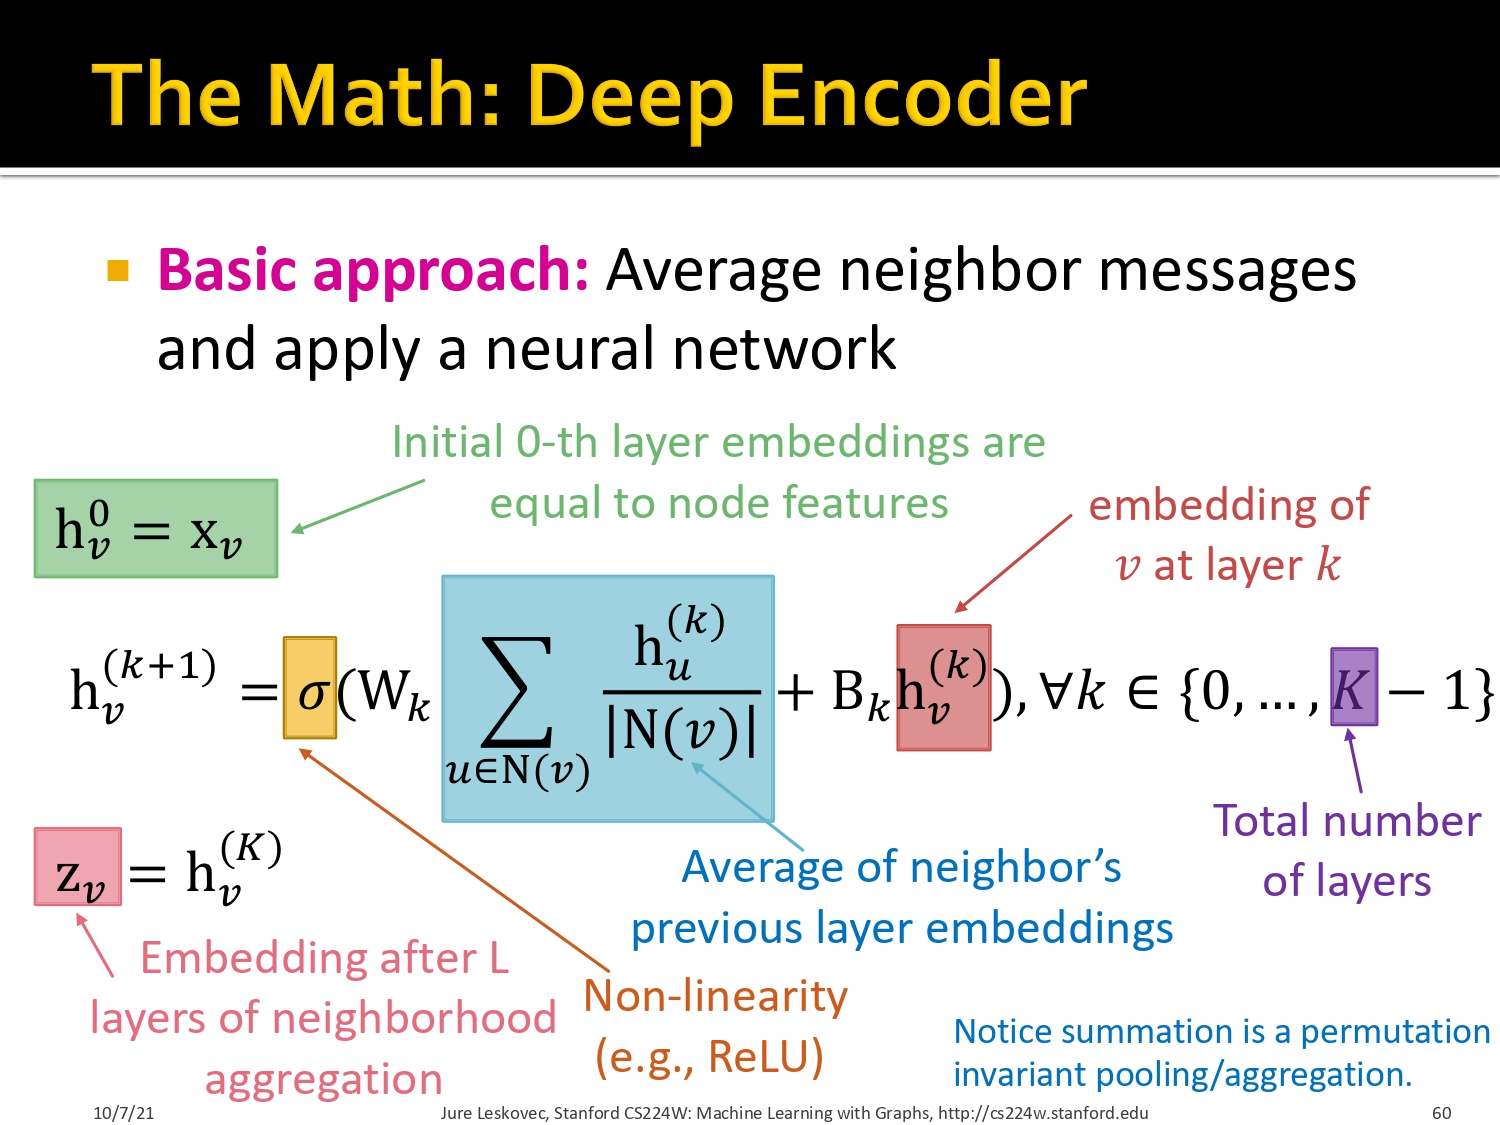

##Reminder:

#Message passing

Object-Oriented Implementation

In [ ]:
def message_passing(G):
    """Object-oriented message passing operation."""

    G_new = G.copy()

    for node, data in G.nodes(data=True):
        new_value = data["value"]  # assuming the value is stored under this key
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            new_value += G.nodes[neighbor]["value"]
        G_new.node[node]["value"] = new_value
    return G

Linear Algebra Implementation

We know that every graph may be represented as an adjacency matrix A, whose shape is (n_nodes, n_nodes). As long as we maintain proper node ordering, we may also define a compatibly-shaped matrix F for node function values, whose shape is (n_nodes, n_features).

Taking advantage of this, in order define the “self plus neighbors” message passing operation in terms of linear algebra operations, we may then modify A by adding to it a diagonal matrix of ones. (In graph terminology, this is equivalent to adding a self-loop to the adjacency matrix.)

Then, message passing, as defined above, is trivially the dot product of A and F:

In [ ]:
def message_passing(A, F):
    """
    Message passing done by linear algebra.

    :param A: Adjacency-like matrix, whose shape is (n_nodes, n_nodes).
    :param F: Feature matrix, whose shape is (n_nodes, n_features).
    """

    return np.dot(A, F)

N-degree adjacency matrix

The adjacency matrix represents connectivity by degree 1. If we take the second matrix power of the adjacency matrix, we get back the connectivity of nodes at two degrees of separation away. More generically:

In [ ]:
def message_passing_n_hops(A, F, n):
    """
    Message passing done by linear algebra.

    :param A: Adjacency-like matrix, whose shape is (n_nodes, n_nodes).
    :param F: Feature matrix, whose shape is (n_nodes, n_features).
    """

    return np.dot(A.power(n), F)

[Example](https://towardsdatascience.com/the-intuition-behind-graph-convolutions-and-message-passing-6dcd0ebf0063)

we can stack node feature vectors in a matrix X and multiply them by adjacency matrix A, then we obtain updated features X` that combine information about node closest neighbors.

So every node gets information about its closest neighbors (also called 1-hop distance). Multiplication on adjacency matrix propagates features from node to node.

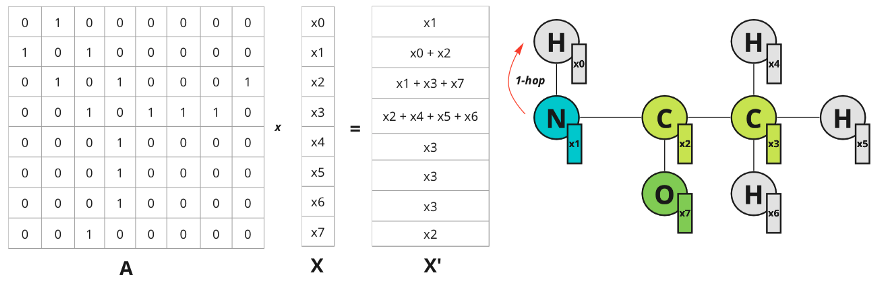

In the image domain, we can extend the receptive field by increasing the filter size. In graphs, we also can take more distant neighbors into account. If one multiplies A² by X, the information about 2-hop-distant nodes propagates to the nodes.

Higher powers of matrix A behaves in the same way: multiplication by A^n leads to propagation of features from n-hop distance nodes. So we can extend the “receptive field” by adding multiplication to higher powers of the adjacency matrix.

If one repeats the graph convolution several times, it can lead to graph over-smoothing, where every node embedding becomes the same average vector for all connected nodes.

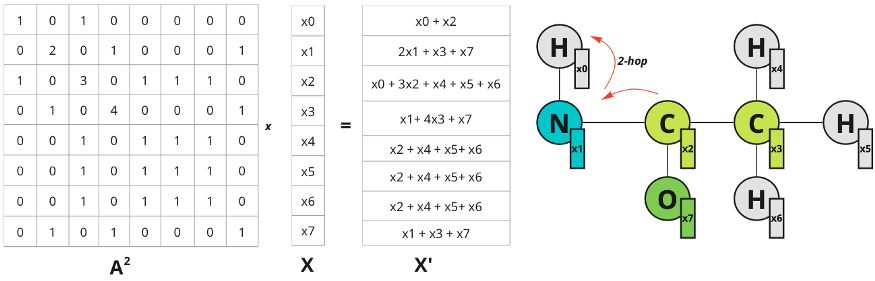

#Self-loop aggregation.

in order define the “self plus neighbors” message passing operation (**i.e. the node send a message to itself**) in terms of linear algebra operations, we may then modify A by adding to it a diagonal matrix of ones. (In graph terminology, this is equivalent to adding a self-loop to the adjacency matrix.)

So now if we multiply the graph feature matrix X by (I + A) we obtain the following:

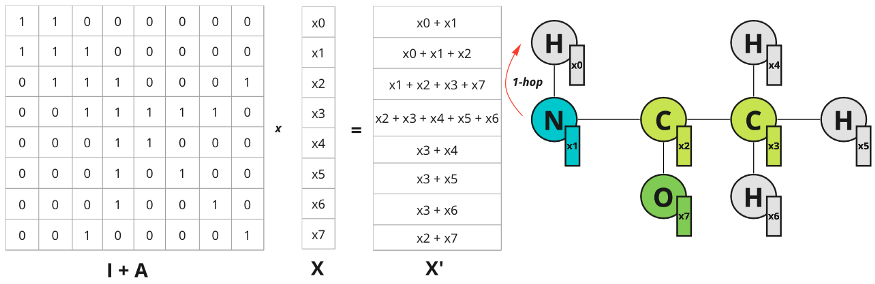

# Let's calculate several propagation matrices based on the basic adjacency matrix

In [ ]:
#get Cora adjacency matrix from graph g_nx

A = nx.to_numpy_array(nx_g)

In [ ]:
def normalizeAdjacency(W):
    """
    NormalizeAdjacency: Computes the degree-normalized adjacency matrix
    Input:
        W (np.array): adjacency matrix
    Output:
        A (np.array): degree-normalized adjacency matrix
    """
    # Check that the matrix is square
    assert W.shape[0] == W.shape[1]
    # Compute the degree vector
    d = np.sum(W, axis = 1)
    # Invert the square root of the degree
    d = 1/np.sqrt(d)
    # And build the square root inverse degree matrix
    D = np.diag(d)
    # Return the Normalized Adjacency
    return D @ W @ D 

In [ ]:
#add the self-loop
A_ego = A + np.eye(len(A))
#normalize by degree
A_norm = normalizeAdjacency(A_ego)
#power of 2
A_2 = np.linalg.matrix_power(A_norm,2)

###Plot the simplified embeddings (i.e. simply multiply A by features)

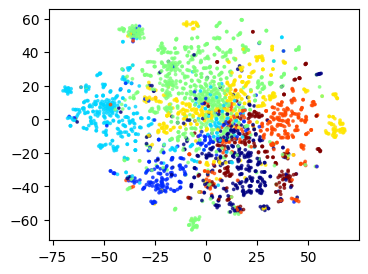

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto',init='random')
alpha =0.7

X = np.matmul(A,g.ndata['feat'])
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(4,3))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=label.tolist(),
    cmap="jet",
    s = 3,
    alpha=alpha,
)

###Now with A_2 ( = A + ego + normalize + power(2) )

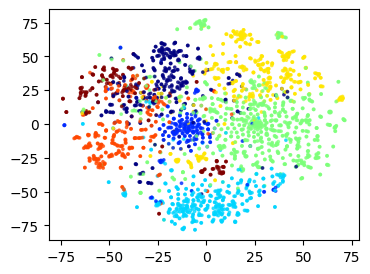

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto',init='random')
alpha =0.7

X = np.matmul(A_2,g.ndata['feat'])
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(4,3))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=label.tolist(),
    cmap="jet",
    s = 3,
    alpha=alpha,
)

###Apply a classfier and compare to the full GCN results

In [ ]:
clf = LogisticRegression(random_state=0)
X = np.matmul(A_2,g.ndata['feat'])
Y = np.array(label)
X_train = X[train_mask]
X_test = X[test_mask]
y_train = Y[train_mask]
y_test = Y[test_mask]
clf.fit(X_train, y_train)

print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.9
score on X_test 0.767


##we can propagate the node features through different adjacency matrices



*   ***X*** - Only data (without structure)
*   ***AX*** - No self-loop aggregation (for heterophilic graphs)
*   ***(A+I)X*** - Self-loop aggregation (for homophilic graphs)
*   You can also use powers of the aggregation to explore more hops






## The optimal feature propagation pattern depends on the type of the graph:

![crop3](data:application/octet-stream;base64,/9j/4AAQSkZJRgABAQAAYABgAAD/4gIoSUNDX1BST0ZJTEUAAQEAAAIYAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAHRyWFlaAAABZAAAABRnWFlaAAABeAAAABRiWFlaAAABjAAAABRyVFJDAAABoAAAAChnVFJDAAABoAAAAChiVFJDAAABoAAAACh3dHB0AAAByAAAABRjcHJ0AAAB3AAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAFgAAAAcAHMAUgBHAEIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z3BhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABYWVogAAAAAAAA9tYAAQAAAADTLW1sdWMAAAAAAAAAAQAAAAxlblVTAAAAIAAAABwARwBvAG8AZwBsAGUAIABJAG4AYwAuACAAMgAwADEANv/bAEMACAYGBwYFCAcHBwkJCAoMFA0MCwsMGRITDxQdGh8eHRocHCAkLicgIiwjHBwoNyksMDE0NDQfJzk9ODI8LjM0Mv/bAEMBCQkJDAsMGA0NGDIhHCEyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMv/AABEIAaoB9gMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABQECBAYHAwj/xABbEAABAwICAwYQCAoHCAEFAAAAAQIDBBEFEgYhMQcTNEFRchQVIjIzUlNhcYGRkrGzwdEWI1Rzg6Gy4Rc1YnR1gpOiwuIkJidCVWTwCCU2N0Rjo9JDGFal4/H/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAQIEAwUG/8QAKxEBAAEDAQcDBAMBAAAAAAAAAAECAxEEEhMhMTIzUQUUIyJBcfA0gdFS/9oADAMBAAIRAxEAPwDvwAAAAAAAAAAAAACE0ix52BRwPSnSbfVVNb8trW7y8pAfhCf/AIan7f8AlOtFi5XGaYcK9TbonZqlvQNF/CE//DW/t/5R+EJ/+Gt/b/ylvbXfCnvLPlvQNF/CE/8Aw1v7f+UfhCf/AIa39v8Ayj213we8s+W9A1Gg0zfW75ehRmS3/wAt73v3u8Zvwld8l/f+45zbqpnErxqLcxmJbCDXvhKvyX9/7h8JV+S/v/cRsSnf0NhBr3wlX5L+/wDcPhKvyX9/7hsSb+hsINSxHTN1BCyRKFH5nZbLLb2EZ+EiT/C2/t/5TpTprtUZiFKtXapnEy6ADn/4SJP8Lb+3/lH4SH/4W39v/KX9pe8I97Z8ugA5/wDhIf8A4W39v/KPwkP/AMLb+3/lHtL3hHvbP/ToANOwvTd+JSyMWgSPI2+qW9/qJXp+uv8Ao37/ANxxqt1UTip0p1NuqMxKcBB/CB3yZPP+4fCB3yZPP+4jZlbf0JwEH8IHfJk8/wC4fCB3yZPP+4jZk39CcBBpj7vk37/3Fen6/J/3/uGzJv6E2CE6fr8n/f8AuHT9fk/7/wBw2ZN/QmwQnT9fk/7/ANw6fr8n/f8AuGzJv6E2CGZjivdboe36/wBxf04XuP733DBvqEsCJ6cL3H9/7h04XuP7/wBxBvqUsCJ6cL3H9/7h04XuP7/3A31KWBELjLkS+8J5/wBxb08X5P8Av/cTg31CZBDdPF+Tp5/3Dp4vyf8Af+4Yk31CZBDdPF+T/v8A3Dp4vyf9/wC4Yk31CZBG0eJrV1CRb1l1Kt81yRIXpqiqMwqCi8Vjlml27H8FNKKzBekPRXQ2T47ozJmzMa7ZkXtrbQtDqgOIf/UKv/2x/wDkP/1m0aB7qa6cY7NhnSfoLeqZ1RvnRW+Xs5rbWyJ23KE4dHBRpUIAAAAAAAAAAAAKLxAVugNboscxXE4emFBhVPJhjpFbE59UrJpWIts7WZMqIu1EVyKqbbbDMXSTCm4mmHOq7VKybynxblZntfJntlzfk3uBMAhH6U4M2SeJapyvgc5suSF7kYrXZVRVRLXvxbV2oZuG4rR4rHI+klc5YnZJGSROjexe+16I5PGgGs7oPB6Hnu9CGie43vdB4PQ893oQ0T3HraTtQ8PW96QAGllAABMYF/1H6vtJgh8C/wCo/V9pMHn3+uWq10gAOToAACH0i4FH857FNb95smkXAo/nPYprfvPT0vbZL3UAA0OXEAAOKe0Y4TUcxPSbOaxoxwmo5iek2c8nVd2W2z0gAMzrgAAMKoVKIVBgAAMAABh6Q9cvgPc8IeuXwHuUnmtEKAAqnAAAYUd1qnkerutU8i0IAASgAAMM/COHJzVNhNewjhyc1TYSlTdp+lQ+Wd17/mljP0HqIz6nPljde/5p4z9B6iMh3ho9zqm4J/x1Xfo1/rYjlZ1TcD/47rv0a/1sQTl9FoDxqqunoaZ9TVTxwQRpd8kjka1qd9VKUlbS4hTNqaOoiqIH9bJE9HNXxoEPcGCmNYW7EVw5MSpFrUW28JM3Pe17Zb32azOAAAAAAAAAFF8FyoA1TC6PSDA8NiwemoaOphpvi6erkqFYm9cWZiNVbomqyLZbbW8WG7R3FrdKG09MuHLi3TBaxZvjMu/b9lyZeuzdTe+zyG7gDWukuItwHFKWllbTVlTWyzsla9W3a6XNtTWiqzqb8XiPLRXBK7DsXxWuqoOh4auOBsULqt9S9qsWS+Z7ta3zNXbypxXXagBpe6Dweh57vQhonuN73QeD0PPd6ENEQ9bSdqHh63vSAA0soAAhMYF/1H6vtJgh8C/6j9X2kweff65a7XSAA5OgAAIfSLgUfznsU1v3myaRcCj+c9imtnp6btsl7qAAaHEAAE9oxwmo5iek2c1jRjhNRzE9Js55Oq7rdY6QAGZ1AAEqoVKIVCAAAAAB6Q9cvgPc8IeuXwHsUnmvAACoAACjutU8j1d1qnkWhEgAJQAADPwjhyc1TYTXsI4cnNU2EpU3afpOM+V91/Vup4z9B6iM+qD5X3X/APmnjP0HqIyId2j3Ok7icVbPpnWNoaqKmlTD3qr5Id8RU3yPVbMne1945tY6puB/8d136Nf62Ikdi0lZPT0OCTVs6SxU2JxSVcyN3tiNs7K5UutkR6sXWq7Dz0er6WnmxeqWZG0Nfi+SicnVNlc6NiKrVTVlV7X69l7m2qiLt2BEREsiW5CBy9s7UxpkS1jEY7H1kdg6Nb0Qx2+W35Xbcl/jLW2LbMqajqDUsURjUddGoi2tmtrLgAAAAAAAAAAAAAAAANE3SquOkpsPV6OXM9/WonInfOdJjFN2k3kT3m87rXA8M+ck9CHLOU97Q24mxEy8zU26ZuTMpvpxT9pL5E946cU/aS+RPeQgNm5pcNzSm+nFP2kvkT3jpxT9pL5E95CAbmk3NLetGa2KrdUoxr0y5b5kTv8AfNhuljUNCevrfAz+I25Dx9VEU3ZiFopimMQrdBdCgM6FboLoUAGDitE6upmMY5rVa9F6rwKRHSGot2SL6/cbKvWL4UPI7UX66IxClVEVTmWv9IKjukX+vEOkFR3SL/XiNgB091c8qxapa/0gqO6Rf68Q6QVHdIv9eI2AD3VzybqliYHhstFPK97mORWonUk3l754UnXO8BkmS5XNdWZd6KYiMQplGUqCi2FMoylQAaxVuXb0vKhWLavgPUjKXjvTuVBvTuVD2BGR4707lQb07lQ9gMiyONWuVVXiPXlKJtBWUwqCgIFQUABW5kshbvK8qHozavgLxkeG8r3hvK949wMyYeG8r3hvK949wMyYe+FRq2tRdXWqTxC4bwtOapNBssdIfLG6/wD80sZ+g9RGfU/Gh8s7rqf2pYz9B6iMiHdo1jqm4H/x3Xfo1/rYjltjqe4In9eq79Gv9bETI+igAQAAAAAAAAKO7xBTaR/H1DaLCq+vjppN6qJqdGZWuTrmpmcivVOPKi8fHqJ1derlNTw6TENHW1lA7B6utzVU1RTy02RWvbLK56Nc5zkyqmayquqyJYCQqdJaOhdK6sywxtqIoGPWZl3K9GrmVqrdiJm1312RV2ayR6aYe2KB7q+mRlR2ByzNtLzVvr8RqtThOIPqcZqVw58rn4nRVUcSK1VkjYyFJLK5UTVkdqVf7vfQwcRwaaqxvEKurw/E+gcRpI4GspoYJHxtTMj43te12XW5XXatlv3kA3mbFMPp6uOknr6WKplVEjhfM1r3quyzVW6l611IlYlGtVAlUqXSFZEzqnLl2moT0NfQ4tE/C6fEZJ39DMmSrihfA9rcqK9XouZrmpdVsvXJdGrx4dHo9PDilRBXw4s50uKrWxzU0cCxOTfMzHLIrc7cqWaqKuxLJdFA3ta6kSsSjWqgSqVLpDviZ7bet2lGYhRS1PQ8dZTvn6r4psqK7qVsuq99SoqL30NHpsBqGYlLT18WLK9cVdWRzUzIVhdeTOxyvVudLIqIqX2IqJdNRP6K4SuHxYjJPSNiqJsSqpkcqJmVjpXOat+TKqAazutcCwznyehDlvKdS3WuB4Z85J6EOW8p9D6f/Hj9+7z7/XIADc5AAA2zQnr63wM/iNuQ1HQnr63wM/iNuQ8PWd6VZAAZlQAAF6xfCh5HqvWL4UPImAABJAAAMmk653gMkxqTrneAyTlVzXjkAAqsAAC+LavgPU8otq+A9SAAAAAAVTaAm0FZSAAgAABczavgLyxm1fAXkAAAAAAy8N4WnNUmiFw3hac1SaDZY6Q+W911P7UcZ+g9Sw+pD5d3XEvuoYx9B6lhNPN3aNY6luCpbTqt/Rr/AFsRy/KdR3B0tpzW/o1/rYi0ofRAMWvr6bDqbf6qRWRq5rEs1XK5yrZGtaiKrlVdiIilKDEKbEqdZqR7nMa9WORzFY5jk2tc1yIrV2LZUKJZYIWXSfDaevjo5kr45ZKhKZjn4fUJG6RVsiI9WZFTVtva2u5MtAqAAAAAAAAAAAAAAADm+61wPDPnJPQhy3lOp7rKKtHhnzknoQ5dkU+h9P8A48fv3edqJ+uVoK5HDI43OWYUBXI4ZHBGYbXoT19b4GfxG3IapoPDI99cjW31M5PyjcehJrr1H1oeFrZjfSc3iD26Em7n9aDoSbuf1oZdqEYeIPboSbuf1oOhJu5/Wg2oMPFesXwoeZ7TxuhjvI3KiqljG3xnL9ReOKJ4LgW763l+ob63l+olGVwLd9by/UN9by/UDLLpOud4DJMWiVHvcjdeozd7cn/9OVXN0p5LAX727k+sb27k+splKwF+9u5PrG9u5PrJyEW1fAetzxc9sCZpVs1dXKW9HU/dPqUYmTLIBj9HU/dPqUdHU/dPqUjEmYZAMfo6n7p9Sjo6n7p9SjEm1DJTaOI8oamKZytjddbX2Ke1u8VmFoUBdYWIFoLrCwBm1fAXlrbIq3GZOUC4FMycozJykCoKZk5RmTlAzMN4WnNUmiEw1UWsS3aqTYbLHSHy/utpfdPxj6H1LD6gPmHdZS+6djH0PqWF6Obs0ex0bcYo5azTGrjhrqmjclA9Vkp0YrlTfI9S52uS3i4kOeZTqG4UltN639HP9ZGXqjgOuaQ0dRDR4PMrqitZh9fHPUPViOkczK9quysbrVFei2anFsLMClWllxSvkpalkGJ4oi07Egc1UbvTI87mqiK1FViqqr3l4zagcUtemikxPTWBHxvSkwqDfkVW2a+eS7UVOXKxH+BXobCEAAAAAAABRSFqNKcIpK+ooqiomZJTvayZ60su9xuc1HNR0iMyJdHIuteMCbBRF5DFoq+nrZK2OByq6knWCVFS1nZWu8ep6L4wMsAAAU2mKzEKd2KyYa1zlqYoGTuS2xjnOa3X31Y4DRd1fgeGc9/oQ5hy+E6fur8Ew35yT0Icw5fCfR+nfx4/fu8rVdyQAG5nAABum592XEOaz0uN5NG3Puy4hzWelxvJ85r+/LRR0gAMawACBH4twdnOIgl8W4OznEQarXS4XOYAC6gAAJDCuyyc0lCLwrssnNJQzXOpoo6QAHNYAAGHiPB289PQpFEriPB289PQpFGm1yca+YADplUAAGbhnCH8xfShLkRhnCH8xfShLma5zdqOQADmsAAAuwsL12FgAAAAADDNwvhic1SdILC+GJzVJ0hssdIfMm6wn9pmL/Q+pYfTZ8zbqyf2l4v9D6lh0tdTtLScp07cMS2m1b+jn+sjOa2Ombh3/GtZ+jn+sjOtcfTKId/ABmWAAAAAAAADR1wGbG8a0ppJqyWnoJ6uFJomRoqzM6HivZy7L2VNXfN3UIm3v7QObYzMtDhukWGTQVKVNTikdRFlhcrHxqsTsyPtlsmVUW67UtxpfDxOnY7ENKVigxDp06vY7C3xNkRu+b1El2uTqdqWddetTXqOq+Upbj40A55j+F/EaV4qiVDa6nrYVopGvX4tUhp7OYmy6qqoupb7D0xaircOdjuF4Gyojhfh9LKxkTnK7MssjZlZr69Y0TYt1VE5Tf7IqLdPCVRNYHMY6aZMHxV2H1CvppI6dJ6aipp4cjElTfVRHqq51jV6LbXqTj2y2ikVDHpriq4ZDUx0C0NO2JZWSNaq55Vdkz8Wu621XVTeLBE8XgA53ur8Ew35x/oQ5hy+E6fur8Dwznv9CHMOXwn0fp38eP37vK1XckABuZwAAbpufdlxDms9LjeTRtz7suIc1npcbyfOeod+WijpAAYlgAAR+LcHZziIJfFuDs5xEGq10uFzmAAuoAACQwrssnNJQi8K7LJzSUM13qaKOkABzWAABh4jwdvPT0KRRK4jwdvPT0KRRptcnGvmAAuqAADNwzhD+YvpQlyIwzhD+YvpQlzPc5u1HIABzWAAAXYWF67CwAAAAAAzcL4YnNUnSCwvhic1SdIbLHSHzVuqJfdKxf6H1LD6VPm3dST+0jFvofVMO1iM1O0tKynStxFLaaVn6Pf6yM5zlOk7iiW0zrP0e/1kZ3uR9Eoh3oGDiuKQYRStnnbJIskjYo4om5nyPctmtRFsnlVELcMxSDFoJXxNkjfDK6GaKVER0b27UWyqnGi6lVNaazEskAQzMfjlxOSlp6CtqWRTJBLUxMasUb9V0VVVFW10uqIqJ4iYaBUAAAAAAAAAAAAAAAHO91Zquo8Msir8Y/YneQ5jvb9fUO8h1TdO4Lh3Pf6EOb+M+h9PqxYiP3m8XWXMXZhh72/tHeQb2/tHeQy/GPGbdpm3ssTe39o7yDe39o7yGX4x4xtG9lsugkjKeSuWZ7Y0VGWV62vt5TdOjqT5VB+0Q51hPWz+FvtM88jVWIruzVMutN+Yjk3bo6k+VQftEHR1J8qg/aIaUDP7WPK3uJ8N16OpPlUH7RB0dSfKoP2iGlAj2seUe4nw2fE6mCWnakc8b7O15XopF74zt2+Ujm9jdzk9pbxbTpTainhlWq5M8UnvjO3b5RvjO3b5SN8Y8ZbdwrtpLfGdu3yjfGdu3ykb4x4xu4NtsWEua6aSzkXqeJe+S1jX9HeET8z2mxmK9GK8NVqc0rLLyCy8heDi6LLLyCy8heAMKvY98DUaxzlzcSX4lI3oefuMnmqT4OlNyaYwrNGUB0PP3GTzVHQ8/cZPNUnwTvZ8I3cIDoefuMnmqOh5+4yeapPgb2fBsIvDopGTvV8b2pkVLq1U40JQBClVW1OVojAACqQAAOIsspfxKALLLyCy8heALLLyCy8heAMrC+GJzVJ0hMN4YnNUmyGyx0h84bqKX3RsV+h9Uw+jz5z3T2/2i4r9F6pho00Zr/p2lpuU33clw+LENK6qKaSpY1tE516eokhdffI+Nioqp3r2NFynRtxhLaY1f5g/1kZpvR8cqw6jj2FzR0OFPo46iq6XV0dQsbpFkkexEc13VPW7lRHqutbrY88EbW0smIYhNh1Q1cTxRHNgXKjoY8jI0e9L6usVy6760NoB5y7n0WCV1Hi0nQ2HVK4g7FnVLK9X/EpTPkzPb11+sVzctuusp0BqFQAAAFskjIo3SSPaxjUVznOWyIibVVTAix7CJ6eWop8To54oVtI6GZr0at7WWy6tZEabtauHYc+pS+HR4jDJXI5FVu8pdbvRP7qPyKt9WrXqMfSSrwqrwSsTDqiikrUgbldCqPys3xlr5V2XtZLpx22KBt6bNWwrfVc0quq36POxmCWtr6qljoIZ2ukmRJWPc+Riqkip1KLZq3XU2yqhCxYzikUekVB0cxeh4KeaB8da6qWFznuaqLIrWKvWtVW67cusDp9xfVc0Ospa6DF8Vw9mN4jvFLhcdbGqy3dvqulbdXbVb8Wi5dmtTArMZxXE8Rgj6KbSK/DIKuFFrOhWq96KrnXyu3xEVETLqRLX13A6KyqgfVyUrZGrPExr3xoutrXKqItuRVa7yKe3fuc5xDEsSoo8Zr4polr0wXDVfPDZzGq6WZHvatluiXc5NVtWwtlxPFcPwjEHsxKLoZ7Ke0qV6VclM10qNklzK1LNyOvrRURWqqagOkA53LX1VMmPUGH41UVNPCtCsdU+RJXQSSS5Xszf3kyo11l7ddiKbLgyT0eP4lhbqqeop4qanqI1qH53tdI6ZrkzbVT4tF17L6tQEBuncGw7nv8AYc2Ok7p3BsO57/Yc2Pf0HYh4Wt70gANrIAACTwnrJ/C32kimwjsJ6yfwt9pIpsMN7rleOQADkkAAFydidzk9paXJ2J3OT2lpX7p+wACQAAQmdHeET8z2mxmuaO8In5ntNjPP1HW2WekABwdQAAAAAAAAAAAgCAAAAAADiUDiUAAAAAAGZhvDE5qk2QmG8MTmqTZDZY6Q+d901L7oeK/ReqYfRB89bpbb7oWKfReqYatHGbn9OtXJp+U6JuNJbTCr/MH+sjOfZToe46ltL6v8wf6yM2aiPimVYdvAB5LoAAAAALXNRyKjkRWqllReMx0w6iSOSJKOBGSKiyN3ttnKi31pbXymUAPJYI3Oc9YmK5zMiqrdapyeDWurvnl0vo1j3taODJlRuXektZNaJbkRdZlADxdBE9XOfDG57m5HKrUW7derwa11d885cPo5oWQy0kEkcdsjHxorW22WTiMoAeSQxo5ypGxHOajVVGprROLwazzp6KlpWvbT0sMLZFu9I2I1HL30RNZkgDHZR0zIFhbTxNiujt7axEbfbe3hRPIeyMakjpEamdURqutrVEvZPrXylwA0HdO4Nh3Pf7Dmx0ndO4Nh3Pf6EObHvaGqIsxDw9bTM3pAAbNqlk2agADapNmpJ4T1k/hb7SRTYR2E9ZP4W+0kTFdmNuV8TgAByzBiQADMGJXJ2J3OT2lpcnYnc5PaWkZTicAAGTEgAGTEpnR3hE/M9psZrmjvCJ+Z7TYzBf62u1wpAAccOoABgAAMAABgAAMAEBRBiRUADEgABiQ4lA4lBGAABOAAAwMzDeGJzVJshMN4YnNUmys8Gyx0h8+7pKX3QMU+i9Uw+gjgG6Ol9PsT+i9Uw26CPln8OlfJqOU6BuPpbS6q/MX+sjNDym/bkWrSyqv8hf8AbjN+pp+GVKZ4u1gjMaxVMIpYZGwLUTzzsp4Ikejc73LxquxERFVdupCmC4v02hqd8p3U1RSzup54VejsrkRF1Km1FRyKi24zw3ZKA1+g0hnxDE5qWHD273DUSQvkWpajkyOVquybbaifQCoAAAAABexTMmZW3S6a1S/+uQCoAAAAACmZuZW3S6JdUuVA41/tAKrcNwNUVU+Nm1oveacKzv7d3lU7p/tA/izA/nZfQ04SMzH3WimJ+yud/bu8qjO/t3eVSgG1PlOzHhXO/t3eVRnf27vKpQDanybMeHTtyBznVGL3VVs2LavfedUOVbj/AAjF+bF/GdVO1Mzh5mpiN5IAC2ZcAADMjwquxJzveYWvlM2r7CnO95hHWmZw51GvlGvlALZlU18o18oAzIy8PVUfJzTP8amBQde/wGfynCvm60cjXyjXygFVzXyjXygDA8p+xp4TGupk1HY05yGMXpiMKTPE1/6Qa/8ASAFsQZk1/wCkGv8A0gAxBmXhVKqQ375hXXlUzavsHjMI6URGHOqeJdeVRdeVSgL4hXKt15VF15VKAYgyyaRVzu16svtMq5iUnXv5ntQy1OVXN0pmcF++L98oCuITmVb98X75QDEJzKW0eX/eqcxTbzUNHfxqnMU24z3Ob0NN0KnA90VL6e4l9F6pp3s4Puhp/XvEvovVtNnpvG7P4/xe7OIanlNz3NMMo8T0kqIa2mjqIm0jno2Rt0RyPYiL9amo5Te9ydLaV1P5k/7bD0tXHw1OVE/Vh0TGMEd0BhqYTTxo7DaxlTHTo5GI5ERzXNRdiKqPdbv8m0swmjxOgfW1ktHG6fEsRSWSJJk+IiyNYiqtrK5EYi2TltfjNkTjB881NPrMFqa7HKR8GA0dD0PXdEvxBJG53sRVuiI1Lqr02o7VZV2qbel9dyoAAAAa/ppDI/RWsqIGuWoo8tZFlWy5onI/0NVPGbAWTRMnhfDI1HRvRWvavGi7UA5ZiGNOpanEdIYEVY8USpw+lcidc9jY2w6+c2df1jY2x1uEursOwelhfU0WE0DYsqNRzk3ydrtaqiLZGqqIuq698nl0dwlcPpqBaCJaWklSaCJbq1j0VVRfK5fKe9XhFDXb/wBE0zZFnZHHKt1RXNY5XNS6ciuVfGBrHT2ufRUlHS18iV1ViKUkktZSJHJSpvayWcxLNVVRupdnVptsZVZNjEeKYZgcOKta+pinnkrH0zVcrY8iIxretuue6rbYmrbqll0cwh2GPw51DG+le/fHMequVz0tZ6uVcyu1J1V76tpZLozg9RRRUs1Ej44nrJEr3uV7HLqVUffMirrvr13A12kxzG8WmwaihrIqWSobXNqqhkKOzLTysjR7EddEzXVbLdOq7xd09xqrwqhrI99ZTtdUx1s1HA2V7XxSrG1d7VVXK7I9VtddiajaoMIoKboRYKSOJKON0VOjEtvbHWzInhyt8hiTaMYRPHGySiarWK9Uaj3NS73K517LrRVVVW4GvYnjc9PS4tX0M8E0keEUNRFVNiRN9zyT6129Stromu2ZSbwefEqfGKrDMRrGVispYqhsrYUjW7nPa5qomq3UJbj161XaZ8+DYdVRzRS0kasmiZDIiXTNGxVVrdVtSK51k75ktpIUrHVeS07o0iV99rUVVRPKq+UDkH+0D+LME+el+y04Sd2/2gfxZgfzsvoacJIXp5AACQAAdN3H+EYvzYv4zqpyrcf4Ri/Ni/jOqnajk8zU9yQAFmcAAHhV9hTne8wjNq+wpzveYR1o5OdQACyoAAMug69/gM/lMCg69/gM/lONfN1p5AAKwsAAJeVR2NOchjGTUdjTnIYxelSeYAC6AAAeFX2DxmEZtX2DxmEdKOTnUoACyoACRkUnXv5ntQy1MSk69/M9qGWpxr5utPJQAFUgAJEto7+NU5im3Go6O/jVOYptxmudT0NL0BwrdCS+nOI/Rerad15Thu6Cl9OcR+j9W02+l96fx/idROKctVym9blKW0pqfzJ322GkZTedypLaUVP5m77bD1dbHwVM9qr64h2EAHzUPQAAAAAAAAAAAAAAAAAABxn/AGgfxZgfzsvoacJO9bvmrDsEWyKu+y7UvxNOHZ7/AN1nmJ7i0UZ4pirDGBk5vyWeYnuGb8lnmJ7id3KdpjAyc35LPMT3DN+SzzE9w3cm06JuP8Ixfmxel51Q5juRLeoxbU3rYtjUTjdyHUvEXiMRh5uo41ysunKLpynp4kHiQlxw87pyi6cp6eJB4kBhiVS/EpzveYRnVy/EpzveYGZTrRycq+aoKZlGZS6qoKZlGZQMyg69/gM/lMDDlvI/wEjfacK+brTyWguuLlIXWguuLkjwn7GnOQxiRaiO1Oaip30K73H3NvmkxVEI2UaCS3tnc2+aN7Z3Nvmk7yEbKNBJb2zubfNG9s7m3zRvINlDVXYPGYJsksUSs1xs29qh4bxD3KPzU9xem7EQrNuZQQJ3eIu5R+anuG8Rdyj81PcW30K7uUECd3iLuUfmp7hvEXco/NT3DfQbuUVSde/me1DLUz4IYs7vio+t7VOXwHvvMXcmeanuOdVyJleKOCIBL7zF3Jnmp7hvMXcmeanuI3kJ2UQCX3mLuTPNT3DeYu5M81PcN5BsqaO/jVOYptxAYTGxtcitY1FyrsSxsBxrnM5b9NGKFDh+n6X03xH6P1bTuCnEdPUvptiP0fq2m/0vvT+P8U1k4t/21ixvG5altJ6n8zd9thpWU3Hc3qqai0jnkqaiKBi0rmo6V6NRVzs1XXj1KerrexUxWKs3IdiQENi+NtpKKikod5qpa2pZTU6758WrlvdVVt9SI1y+IuwHFJsRZWw1cLIqyiqXU87Y3K5qrlRzXNVbLZWuauzbc+Zh7CXBrdTpI9mllBhFNCyWGWV0NTKqreOTenyNanEq2Zdec3lNjQCoAAAAAAUd4AK3F0NPwimk0kSvxGtr8Qhe2smp4YaepfEyFsT1Yi5WrZ7ltdc6LrW1rIhTEtJsUo34zPT01JNh+C5W1bpXuSWVcjZHqxESyWa5FRFvddWoDcdouahU6Q4r0VpAtLT0nQeENzK6VXK6b4hsqIiJs1u1qvtuXR6U1dHGyTGKaBkc2HTYhH0OrlVGxI1XNdfjVHourVtTXZFUNtBozNI8Uq6Kqjq6WJjZsPlla6nSRFgkRqrvbnOREdqvZzeNF1bL52js80uO5JJZHsTA6F6I5yqmZXTXd4Vsl147IBpO75+LcE+dl9DThZ3Pd8/FuCfOy+hpww608kAALAAAOmbkPCMX5sX8R1NDlm5DwjF+bF/EdTQhgv8AXIAA5AAAxa7sLecntI4ka7sLecntI472+TjXzAAXVAABnYb2STwEhykfhvZJPASHKZ7nN2o5AAKLAACV8e1S8sj2qXkAAAAAAsl6zxnie0vWeM8SYQAAlAAAYekPXO5vtPc8Ieudzfae5WVoAAAAAGbhfDU5qk8QOF8NTmqTxSptsdKinFdPE/rpiH0fq2nazi2naX0zxD6P1bTf6X3p/H+OGvnFuPy1mxuG5xTQ1GkVQyeKOVnQjlyvajk69nEpqeU3PczS2ks/5o77bD1dbPwVPP00/LDfsYwV1XS0SUG8wS0NUyqhYrcrFVLo5q22IrXOS9l2njh+F4pQdE1DZKR9XXYglRVZs2VsWVrMrF2qqNY2yrbWbAmwHzUPeae7QhsWJ4dUUmIVrY4KySqn3ya7nOdG9qq3VtVXJflS5t6FQAAAAAACjr21FQBCTaNU7quoqKerrqNKh2eeKlnyNkdxutZVRy2S6tVFPGs0Qw6tq5Z3uq2MnRiVFNHMrYqjIlm52316rJtS6IiLc2EARjsDpHNxZLPTpon9Is7b8WkerVq6lqFrsBonSUTpI3SdCUz6ViOW6OjejEcjktrvkaSoAgabRampqd1M2txF1KsLoGQSVGZkbHJayXRV1JqRVVbGdQ4PTUFQlREsiy9CxUt3OvdkauVvj6t2skABx7d8/FuCfPS/ZacLO57vn4twT52X0NOGHWnkgABYAAB0zch4Ri/Ni/iOpocs3Iez4vzYvS46mhDBf65AAHEAAGLXdhbzk9pHEjXdhbzveRx3t8nKvmAAuqAADOw3skngJDlI/DeySeAkTPXzdqOSgAKLAAJF8e1S8sj2qXlZSAAAAALJes8Z4ntL1njPFCYQAAlAAAPSHrnc32nueEPXO8HtPcrK0AAAAADNwvhqc1SeIHC+GpzVJ4pU22OkONacp/XKv+j9W07Kcd03S+mFf9H6tpu9NnF2fx/jP6h2o/P+tasbjuapbSSf81d9thqeXvG37nCW0jn/ADV322Hpaufhqebpe7S6mmwFE2FT56H0IAAAAAAAAAAAAAAAAAAORbuyN6X4Krmo5Ell1LfkacStF3Bnld7ztm7v+LsF+dl9DTiZptxGygtH3BnlX3i0fcGeVfeAdMQgtH3BnlX3i0fcGeVfeAMQOk7kjWLUYtaNreoi2KuvW7lOpb2y69Shy7cj4Ri/Mi9LjqfKcK+bFe6lu9s7RBvbO0QuBVyW72ztEG9s7RC4AYdbGzem9SnXGBkj7RPr95I13YW84j0O1ueDnXCmRnaJ9fvGRnaJ9fvLgWVW5Gdon1+8ZGdon1+8uAGVh8bN8k6hE6kkN7Z2qGDh/ZJOaSBwuc3WmOC3e2dqg3tnaoXAplZbvbO1Qb2ztULgMyLcjU2NRBZOQu4iiExIpZOQWTkKgIUsnILJyFQSKK1rksrS3e41/uoXhOMjIs3qPtRvUfal4JFm9R9qN6j7UvAFGsa26o3iK6uQqmxSgDxDxAAPEPEABm4Xw1OapPEDhfDU5qk8UqbbHSHIdNE/rdX/AEfq2nXjkumTf62V3hZ9hps9P4XJ/DP6h2o/P+tdyqbbueJbSGb81d9ppq2U2LQ2vpMMxiWesnbDGsDmo5yceZq+w9DVT8VTzdL3aXVU2X4ipAYrjipQYe/CpI3uxGrbSwzOarmsujlV1rpeyMdq5T1wHEaqsdiVHW5HVOH1XQ7ntblSRqsa9rrXWyqj08inhQ+hTQNSqcaraLSulw/plS1PRE+9uo0pXRuijyqudJFcqKqarpbXfVY2xAKgAAAAAAAGp4702o8TwxIMcqI4sQrlp1j3iFUjbvUj0sqsVVW7E28VzbCPxLDG4jPh0qyOY6hquiWoiXRy5Hssuvkeq+JAIWs0n6TyS0DmSYhPSxo+oldJHCrs2tGtatszra7NTZbjVEX2q9LYKSaOFKaWV9XGyTDt7XVWZlRFRL9arboq32IqLyonrW6OukxaXEKOqZA+oa1lQyWnSZrst0RyXsrVstl1qioiak2lKjRlKydKmqrJHVcUaNpJ2sRvQypZVVqbLuVOq4lTVqQDHxjTGnwKrbDiDKeNt40X+mx74ufUrmxquZzUvrXUupVRFMmHSFarHKjDaSlZKtLKkU7lnax6akdmSNdats5Neq9ltcwsS0OmxDpgzppvcOIyMlqWNp0VXOa1rdTlddG9Q1cuvWm2yqhmVmjj8QxinrKyrjkippmzQtbTNbK1Wqqo3fb3y34rJfYt7qBoG7r+LsF+dl+y04odr3db9LcFv3WX7LTihqtdKAAHRAACB0rcj4Ri/Mi9LjqfKcs3I+EYvzIvS46nynCvqYr3VIACrmAAIYtd2FvOI9CQruwt5xHodbfJzq5qgAuqAADMw/sknNJAj8P7JJzSQOFzm7U8gAHNIAAHEUQrxFEJgAASgABIBOMBOMgAAAABIqmxShVNilAAAAAADNwvhqc1SeIHC+GpzVJ4pU22OkOU6YNvpVW/qfYadWXYcu0ubfSis/U+whq0XC5/TP6h24/P+teym06BN/39N+bu+001vKbRoIlsdl/N3faabdRPxS87Sx8tLcMbwl2LUkDYp94qaedlRBNkzo17b7W3S6KiqipdNpj0OBVdBDIrMT/pNRW9F1kradLTJZGqxrVVcqZWtS91VLE6gPHfQNfq8CxHEcRgfW4rE6hpqttVFTw0uR6q1bta6RXLdEW2xqX5SfTlKgAAAAAAAAAAAAAAAADkO7v+LsF+dl9DTifKd/3XsPgxCjwts6yI1j5FTIqJxJyopyn4O0C7XVPnt9x6On09ddEVQy3NVbt1bNTVgbT8HMP7ap89v/qPg5h/bVPnt/8AU7e0u+FPe2mrA2n4OYf21T57f/UfBzD+2qfPb/6j2d3we9tNh3I+z4vzIvS46nynLNF3t0a6Llomq9ZsjXJM6+zNa1rGw/DCs+Tw+VfecK9Hd2uTNc1NuqrMNyBpvwwrPk8P1+8fDCs+Tw/X7yvsr3hTf0NyBpvwwrPk8P1+8fDCs+Tw/X7x7K94Rv6G0V3YW84j0MKjxyfFEkbNFG1GWXqb98yt9v8A3V8pG7qo+mTbirjD0B577+SvlG+/kr5RiTL0B577+SvlG+/kr5RiTKQw/sknNJAjcMfmlk1W6kk9Rnuc3WjkoCt0F0OaygK3QXQCnEWoX6u+NXfJgWgusnfFk75ORaC6yd8WTvjItKF9k75Syd8CgLrJ3xZO+Mi0F1k74snfGRamxQXWS3GURE74yKAusnfFk74yLQXWTviyd8ZGXhfDU5qk8QWGW6NS1+tUnSstljpUU5lpW2+k1Z+p9hp01Tm+lLb6SVf6n2GmjSziv+nHXduPygcps2g6WxuX83d9ppr+VTY9CktjUv5uv2mmq9PxzDz9NHyw35NgAPMe6AAAAAAAAAGv6U45NgkVCkL6WBKqdYnVVZfeYepcqK6youtURE1pt2gbACB6duw3DIp8VmhqJqmZI6fpdE5+/wB23TK26rsRy7VRES9xR6VYdWxwvjSdqzVq0LWyR5XJKjFeqKm1LI1b31oqWUCeBr9Zj8a1EUNNIrXsxRlBMjo73csedUTXq6lya9fGh5ppphXQdRV5KpKanl3mWZYXI1sm/JFlvxrmVNl9QGyAgX6VUUSMa6lxDf3MWTodKV6yNjRdb3NTYm23Guu17KX0ONpiGPNgppIpaCXD2VcUjUW7sz3J5LIgGs7qPBcN57/QhzVNh0rdQ4Lh3Pf6EOapsPofT+xH793h63vSAA3MoAAhkQdgk5zfaXIWwdgk5zfaXIcauokAAQAACZwDrp/A32k0QuAddP4G+0mjzNR3JaLfSAA4LgAIEhhXZZOaShF4V2WTmkoZrvU0UdIADmsAAAAAAAAAACqcZQqnGUAAAAAAKpsUoVTYpQAAAAAAzcL4YnNUnSCwvhic1SdIbLHSopzvSZt9Iar9T7CHRTn2kjf9/wBV+r9lDvp5xW5a3t/2hcpsOhqWxiX5hftNIPKSuj9azDq980kNTK1Y1bangfK5Naa7NRVtq2mi7P0SxaePlh0EXQ13G8VqFoMLZRLNSuxKtZTb5JFlkiZZznLlemp1mKiXTjL9HKyqlkxagrJnVEmH1m8MnejUc9ixskbmyoiZkz21ImzvmB7KfBq9XPXUOktDTQYtPWVFXM6SWgeyNGR0yXu+7Wo5qNVWoiqq5l1a/wC7szdaAXAAAAABH4qzEnxMTDmUUiKqpLHVq5Gub3lRF9CkgANNp9E66igpqinnpG1tPXyVkcDWKyBEkjVjo02qia1ddE2quoxsLwbEKmnrJLxtxClxx9bGsjXJFI7e0aqcuXq3Ii69ibVQ3soiWA0+HRjE99WepnpXyyY23En5MyIjEhRmVNWtUVNV9Vu+e/wXqfgiuEb7Dvzq/opXWXKrei9/tsvfLqNqAGrY7ozLX4y3FIIqWdy06U8kNRJJHqa5zmuR7NaL1btSoviMrC8Bdh2LR1LGwR07aBlNvceZcr0e5y2vry9Vq1+QnwBz7dQ4Lh3zj/QhzVNh0rdR4LhvPf7DmibD6H0/+PH793h63vSqADcyZAADLIg7BJzm+0uQtg7BJz2+0qmw41dSJVAAAAATOAddP4G+0miEwFeqn8DfaTZ5mo7ktFvpAAcFwAASGFdlk5pKEVhXZZOaSplu9TRR0gAOawAAAAAAAAAAKpxlCqcZQAAAAAAqmxShVNilAAAAAADNwvhic1SdILC+GJzVJ0hssdIaHpA1Fx2pXm/ZQ3w0fHk/33U/q/ZQ62Z+pz1nbRGVOQndFEtisnzK/aaQ+Um9F0tiknzK+lDtcn6ZZLHchsGLYXFi1KyJ8kkUkUrZoZo7ZopG60cl0VF5LKioqKpi0ej7KKBGMrqxZXVfRc82dqPnfyPs1Ey2RqWRE1NQmQZHrNfo9F+gcarMUhxjEN8q5klnic2BzX22MzLFnyompEzak8ZPolr7SoAAAAAAAAAAAAAAAAA59uoq1KbDc17Z37PAhza8fbP81PedH3VOCYbz5PQhzNT6H0/+PH793i6zuy9Lx9s/zU94vH2z/NT3nkDdhlet4+2f5qe8Xj7Z/mp7zyAwcE/gGFNxdKljZ1j3vK66x35e+TPwN2/0/wD8P8xjaC9kr+az+I3TlPF1eouW7s00y00Wqaqcy1X4G/5//wAP8w+Bv+f/APD/ADG1Az+7veV9zR4ar8Df8/8A+H+YfA3/AD//AIf5jagPd3vJuaPDXaTR9MNR7lqd8z2TVHa23vmR0Mnbr5v3knV9iTnIYZWblVfGUbMU8IePQyduvm/eOhk7dfN+89gMyYePQyduvm/eOhk7dfN+89gMyYe2HxJHI9cyrq5CQuhhUfXu8BmIca+MulPJW6C6FAVwsrdBdCgAqqoUzIUXYUQC7MgzIWgC7MgzIWgC9FQXQtaV4gK3QXQoAK3QXQoAK3SxTMg4i1ALsyDMhaALsyDMhaAM/C1vWpzVJ4gMK4cnNUnystljpUU03HG3xmoXm/ZQ3M1HGm3xef8AV9CFrc8VdV0InIpM6NNtiUnzS+lCMykto8lsQf8ANL6UOtU8GSzHyQ2gAGd6gAAAAAAAAAABH4ziTcIwuSrWNZXo5scUSLZZJHORrG+NyolzPNfx3DK/F8Tw2GCV9LSU7nVMlQ1GKqytREjajXXv1zna0tdqcdgMqk0goZdG4MaqZo6OmkiR799eiJE5dSsVeVF6nwnhJpdhMdRTRpUsVk2e772yW1a02619nKQK6NYxSvRjESsgosUTEadsjmsWdHsckjbJZGua9znpeyLclqtcXqajDsUZg0jH00srXUj6iPfFjcy2a6OVt78V18IEmukODtxVMLdiVN0dmRm850zZlRVRvhsirbaelPjOH1dfLRU9XHLVQtV0kbVurURVTXya0VPEvIatNo/ikjanDehInQz4u3EErXSJ1DN8bIqZU6rPqyJqtbapN6N4bNhzcVWogSN1TiU9Q2youZrnal1d5EA1ndT4Jh3Pf6EOZqdM3U+CYdy53+hDman0Xp/8eP37vF1ndlQAG5mAAENv0F7JX81n8RunKaXoL2Sv5rP4jdOU+e1/flstdEAAMjoAADwq+xJzkMMzKvsSc5DDOlPJSoABZUAAGTR9e7wGYhh0fXu8BmIcqubpTyAAQkAAFF2FEKrsKIAAAAAAVaV4ijSvEQAAAAAkOItQu4i1AAAAAADOwrhyc1SfIDCuHJzVJ8pU22OkNVxdt8VmXm+hDajWsUbfEpl8HoQUI1PQjMpKYClq9/za+lDCyqe9JUT0cyyQUFRWvVMu906xo5qdsud7Utq5b69h0meDLaj64bUDWNIKypkocIhy1FAuI18dPM3fEbKxio5ytzMctlXJa7Xce09tGZpVlxnD5J5aiOgrlhikler3KxY2SZVcutVRXqmtbnJ6TYQavTxSUu6A+Lo2rlhqMPfUOimnc+Nrt8anUt2IiIq7PrNnTjAqAAAAAAAAAAAAAAADnm6pwTDefJ6EOZqdi040ertIIaJlFvd4nOV2d1ttu93jTE3Nset/0v7Rfce5otRaosxTVViXlamzcquTMQ08G4fg2x7/ACv7RfcPwbY9/lf2i+42e7sf9Qz+3u/8tPBuH4Nse/yv7RfcPwbY9/lf2i+4e7sf9Qj293/lTQXslfzWfxG6EVozofiuEPqVqUgVJUblyPvsv3u+bH0pqeRvlPD1ldNd6Zpng1W7VcU4mGCDO6U1PIzzh0pquRnnGbK+7q8MEGd0pquRnnDpTVcjPOGTd1eETV9iTnIYhOT4LWSMRrUZtv1xj9IK63/x+eXpqjCs2q5+yLBK/B+u/wC355TpBXf9vzy21CN1X4RYJTpBXf8Ab88dIK7/ALfnjag3NfhiUfXu8BmIetPgtZE5VcjNacTrmR0qqeRvlOczGVot1xHJhAzelVTyN8o6VVPI3ykZTu6vDCBm9Kqnkb5R0qqeRvlGTd1eGCuwtQz+lNTyN8o6U1PIzzhk3dXhggzulNTyM84dKqnkZ5wyburwwQZ3Smp5GecOlVTyM84ZN3V4YTSvEZiYVU8jPKV6VVPIzyg3dXhhAzelVTyN8pTpXUfkeUZN3V4YYMzpVUcjPKV6VVPI3yjJu6vDC4i0z+lVSnEzylOlNTyM84ZN3V4YIM7pTU8jPOHSmp5GecMm7q8MEGd0qqfyPOHSqp5GecMm7q8KYTw5OapsBE0FBPT1KSPRtrKmpSWKy12YmKeIa/iSIuIS+L0IbARlVQSz1L5Gq3KtrXXvCOBepmqnEIfKZ+EJardzF9KF/SuflZ5VMiiopKeZXvyqittqGXCi3VFWZe1fh9PidMkFSxzmte2RqserHNcmtHIqa0VDGhwChgp44WMlRrKjolVWZznPk5XOVbr4FJQENqHdo5RuxdMUWau6KRbovRb0S175LXtkuidTsJdqW5SoAAAAAAAAAAAAAAAAAAACl7bVPFaumbE+V1TEkbHZXvV6Wa69rKvEtz2XZqS6mhvdC/Sh+LLC9MBZUsY9yPtG+rRFbv6pxtTqWX2ZkRdjbgb54ypRCoAAADwjraSaCCeKqhfFUWWGRsiK2S6XTKvHdNeoitK55W4MtFTMe+pr3pSxtjWzrO69yLdLKjEct77UQ1zOtHg2I4HUUjo6pajfcMpkkTO1ZXK5io5LomSRr1vrs1qauIDe2TRSSyRMlY6SO2diORVbfZdOK56Gv6JLveH1NLUK5cShqHdHOeuuSVde+J+S5LK3kTqf7psAFrthCzY+2LCsVxHofNFRPfHGiO6qd7NSomrUue7U23tcnDU3aPVtTC/DZVSGhbiklW6Vrkzyscrpm5UstlbK9Nvc7ptAm8GxNuL4XHWJGsLlVzJInLdY3tcrXtVe85FS/Ha56wV0VRX1dG1r0kpsmdVRLLmRVSxGYTgD8Ofi9PLO6poa16SNSRyrJdzEbIiqiImvKioqcq+FbKLRSjpcWnqVgZvSOjfStSRyrGqJ1V9eu6oi8YHtiWPOoanEII6N07qOhbWqiPRM7Vc9Fal+PqFXyeE8ajSiOCdKfeFfPUsY/Dmo7VWI62zV1OVVRXbbIqLrvYYthlf0XiuIUTI5ZajDW0kMauyrnR0i3VV1ZerTl2L48R+i1Y9kEzapkdVhscceFqirlZlREcr9W2ROpciXRGpq13A2tl7a0RO8ilxbHmypnajXWS6It0v4eMqoEPpBj8WAx0r5YnSNmlVr8q23qNGq58i/ktRNfhQ866sqItIaCnp6uJWvdeamcxOpjVrrPzXujlciIicd1S21W+WJ6OS4xjL6qorJYadlNvELIMqqudV33MjmqllRI0snarfaZGD4KlLhlImIQUlTiVPG1i1ORFc9WamuVype9kS/IoHlT6ROqayPD20Mja5J3xzw59UMbLLvl+NrkczLyq/vLaebsNbosCxGjxBMVSpifX1M39ParnJG+K1msZq1ZLIrbprVX7M6qmyJx7QPCtq4MPoZ6yqkSOCBiySPX+61EuqmBWY7S4cuGR1TJYpK+RsTI1RLsVbJ1Vl1Jmc1uq+tzeK6o0npZqzRutip499lRmdsSf8AyZVR2Xx2t4yFxTAcT0kq62dtVHR0klOyCmzwLI+2qRZE6pMi5smpbr8WmwDbk1Je/jUthmjqIY5oXo+ORqOY5q3RUVLovgsR7qSsxPDKVaipqsNq97R0zaZ7Fs5U1tVVRyKiL6DF0UwapwTAqSnq6yrnlSmiY6KZzHNgVrbK1mVE1X1a1XUieMMikx6lrlpEgZInRbJHQukRER2RbK2/EvHs2IvIYNJpKrKetmxGKPe6SrbTSVFI5XxIqo26qqoiojFdlcutEW+yyokfRYVUJT6PYVUwyRyQOqJqhY35cjHMkZZHsXqVVZUVLKi9Sq8RKTYE3D8AdhOC07mxVCbwqTSulZBGt8zssjlvZFXqUTWqoi6r2CVosQhrZ6yKBHqlLLvL5FTqXPsiqjV47XsvFe6bUW2YQ+j9HU4XTzYbLH/Rqd/9FnzIqyxrr6pNudFuiqvXanXVVW0xYCI0hx2LAaJk8kUkyvc5EZH12VrHSOXxNY5fDZOMjdIMaqcNxTB1pJ45IKuoigliXJls91kftz3W+rKip1K31azJxLR+fFsbjqpa+Wmp4Kd0UTIEarnK9Uzq7O1UtZrUsnf8fvgODLhmG0cFVvU9TRsWniqct370iqjEVbXvltfv32gY8ekzZMRZhXQj+me/ujkgz6mRoiKsua2tlnNsvK621FQn235TW4tH66LFG43v8S4m+RWTtV7t6WmXUkaatrbI5Ft1yu4nKbKm1QPKqqIaOkmqqiRscELHSSPctka1Euqr3rXIyt0gosOpcNlqmTRJXSxxMY5qZo1fayvS9kRFVEVeK6HppLRzYho1iNLTtR88tO9sbFWyPW10aq8i7PGQOKYHX6VVVRLvsVJh8lE2ng3yBZJFR/VSORMzVjVFSNNd1uwDcUXlTaedNUw1lOyogkSSKRLtcmxUIympsSxDR+iZiM9RQYg1rVqFpXMW70RUVLuRyZV2+TWeGiuEVeFYPTMrKmpfMkDWOgkcxWRKibG5UTyqqgZdNjlJWdC72siNqnzRxvVurPG5Uc3w9S5U7zVIym0pkhmxVmK0m8R0Dos8saOsjHq5Myo9GqrGq1erS7V1qmxbY1LhdZFDgVFJEsc0OKVNZIt0VGx5plTWmq7t8Zq768hJTYMmGYVUQYNSLJU1SNhWSqmWbK3WiOesjlVzGoqrlRV22TaqgSlJXw1dRUwQq560zkZI9E6nMqXyovGqIqX5LoZZBaM4XPgNLLhORXUUD1dSzqrcz2uVXK1yJ/eR19dtaKnHcnQAAAAAAAAAAAAAAAAAAAAAAAAAAAAACilEbbXbWXACiJYqAAAAFFS9illLgBRCoAAAAAAAAAAAAAAAAADWUTUVAAAAUsVAAAAAAAAAABEslk2AAAAAsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//Z)

e.g. add ego loops for homophilic graphs

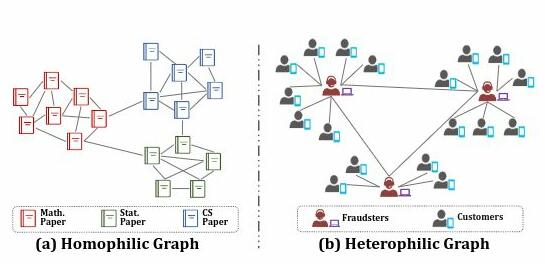

![crop1](data:application/octet-stream;base64,/9j/4AAQSkZJRgABAQAAYABgAAD/4gIoSUNDX1BST0ZJTEUAAQEAAAIYAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAHRyWFlaAAABZAAAABRnWFlaAAABeAAAABRiWFlaAAABjAAAABRyVFJDAAABoAAAAChnVFJDAAABoAAAAChiVFJDAAABoAAAACh3dHB0AAAByAAAABRjcHJ0AAAB3AAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAFgAAAAcAHMAUgBHAEIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z3BhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABYWVogAAAAAAAA9tYAAQAAAADTLW1sdWMAAAAAAAAAAQAAAAxlblVTAAAAIAAAABwARwBvAG8AZwBsAGUAIABJAG4AYwAuACAAMgAwADEANv/bAEMACAYGBwYFCAcHBwkJCAoMFA0MCwsMGRITDxQdGh8eHRocHCAkLicgIiwjHBwoNyksMDE0NDQfJzk9ODI8LjM0Mv/bAEMBCQkJDAsMGA0NGDIhHCEyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMv/AABEIAToB6AMBIgACEQEDEQH/xAAbAAEAAgMBAQAAAAAAAAAAAAAABQYBAwQCB//EAE4QAAEEAgECBAMDBwgFCAsAAAEAAgMEBRESITEGE0FRFCJhMkJxFSNSYoGRsRYzVJKTocHRB1OC4fAkNDVylKLS8SUmQ0Zjg5Wys8PT/8QAGQEBAAMBAQAAAAAAAAAAAAAAAAECAwQF/8QAJhEBAQACAgICAwEAAgMAAAAAAAECEQMhEjETQQQiURQjYXGB8P/aAAwDAQACEQMRAD8A+/IiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgLVZm8itLL5b5eDC7y2Dbn6G9AepPotqwUHNjr1bJUIbtSUSQTND2OHr+I9DvoR6EaXTsKrXmnwpkp8wwkYW07lkIh2rSE/8AOG/qns8f7fo7c1ksrVxONN2w8mPo1jI/mdK53RrGD1cToAD3Qer+Tr0JqkMhc6e1KIooo28nH1c7Xo1o6k+n4kLtGvRQODxVllifMZUtdlLTePltO2VYgekLD/e4+ruvYACeHTaDKxsISoYZiW7nvydj445Iqp/5fYdstjJaeMbfd/VpP6I79SEE0CD2RYAI3tZQEREBERAREQEREBERAREQERYPUFBnYRV3NOt4a7+XK4ms1OLY79QEu1GCdSxt927Jc0faG/UDcs3I1i0OZJ5gcNtLASCPx7KZLfSNuskDudLKg8xnjVrNioxCbITnjBHJ8rW+he8+jG72ddewHcLtw9A43HMrvtzW5Nl8k8riTI9x24gdmjZOmjoBpNJ270TabHuoBFqrWoLkDZ6s0c0Lt8ZI3BzTo66EfULagIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAndarPnCtKazWPnDD5bZHFrS7XTZAJA+oChBN4v6/+jcH3/p8v/8AFBYEVMydnxCLFduVibUokOJkxMkk7jINcQ/82C1uuXbez0P120fE9rGU4W+J6U9JuvlyDgHQuHoZS3+adrW+QDd9j6LHHl8uW8er1rv6NLTOWiCQvHJgaeTdb2PZfOvCeFhdk8ZEyg+OTEMBmlkk5RnnGQwsHI9SDsdBxGx66V9tWSMbJaqxi0BEXxtY7+cGtjifr6Kr+C7fmWctZnZ5DfIquPNwPyiLo4n6gb/ap5Px5yePJbf1v1Vd96XTsCSU30VTd42pS1PNZK2HlK6NjXNL5ZTs6EUTfmeSNH2G/Xque1V8Q5qtBJNTjbjoXgux87musW26IBkcCI2EEg8OoOupHZW5vLjxtk3f4mXaVzGRtW7ZweGl4XXNDrNoDkKcZ9fYyO+63/aPQdZPFYuphsdHRpR8IY99yXOcSernE9XOJ2ST1O1WfCssGFs2sRcojFT2bLp6kZ4mOZpa3oxzehcNHbe49NgbVyHTYTiyuWEys1v6SyiIrgiIgIiICIiAiwSANk6CAgjYKDKIiAiKMueIsHj7Br3czj604GzHNaYxw/YTtBJrTYsMrs5OJJPZo7uUTL4uwPw0k0GYx9gM+15Vpjtb3rej07LhoZmC7b8p4eyw9pczzABzaO/EAnWtjp9Qk1vs1bNxKSOksncx6ekY7D8fc/3KtPmtYHJy16kbJ6c7TYjikeWeS8n5mjodtJO/od+hGrL0AJPRuvX0UH4khis0Kz3MIHxldjZSCAQ6ZjSwH15b4+3XqR3V85l46xVwuMu8mzA13zVhlbmn3rjA557iJncRN/VHr7kk+yl4zJXJdCencscflWNGFgBgfGwD0Z0A/Z2C1Wr1WjWNmzYZFC377jofgPc+w+qtPXaL76SsFls7T9x7ejmnuFXsjJP4myEuFpuLMXXdxyNlpIMjv6PGR6/pu9AePcnURJmbuTlrQUmMrNtvMbZw5zZYmacSQNfa009/snuDrSuOHr1aeMiqU4WwRQDgI2/d/b3O++z1O9+qy6vcaWXHquuCJkELIoo2xxsaGsYwANaB0AAHYBbERECIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiiPEmdg8P4k2pHxefI9sNaOR4aJJnnixu/QbI2fQbPog6K2ZoWsxdxUNgPu0mRvsRgH5BICW9e3UNJ/81ww+L8LPWhninncye66hGPhZeRnbvk3jx2NcXbOtDR69FTsXdreFfG2RGbtUaxjwcU1mRs/Pm4Tyuc87a0guMnRoB7gD0C6PCr4of9IORF1kcVjJ1W5SjXL+Rga48JRrtzdwic7XqSAdN2Q+jb32RYb6rKAiIgwRvS4LFFzfMnqPfFMQTw3tjz9Wnps+40fcrv2NoSEl1ekWbUrFeHMnThknrSMw90yOeYoQJKk+yT80OxxPuWFpPfZ6hRuMuZufJcq0lGnLlTHG5zIzIK4jjdvgDoEnXr0bsdHeshnPE0d23+TKlqWvS80w2b0LTykeCAYISPvbIDn703sPm7SdzwlRbj4hhq1bHX6unU7McI3G4DWnermuG2uB7gn10RXkxztmU6i/HlhJZZuu7FeH6OLlfZaJLF2RvGW7ZfzmePbl6D9Vumj0CltbVS8N57J5K/bZfjjghjmMJjI+eKYAF0ZIPbqeLtfMNH1G7aCFplNVSXblyGMp5am+pfrsngcQeLvQjsQR1DgeoI0R6KJoNzOKvR0LZdkaEhIr3Oglh0CeM36XQdHjrvoRv5jYVghViRu/VZQIgIiICjchma+MlZFMyZ73tLh5bOXQED/EKSVT8SzRQ5im6SRjAa8gBc7Q+01a8OEzz1WfJlccenf/ACqp/wBGuf2P+9P5VVP6Nc/sf96rvx9P+lwf2o/zT4+n/S4P7Qf5rt/y8bn+bNPzeJ6kkT2Cvb6tI6wrkwGangir08m8uMjWiKd56l2h8j/rvoD6/j3i/j6f9Lg/tB/mk0kUsTY2sFkz/KyJmj5n4fTt17aP4bf5+OY2I+XLe1+GtdFlcOIr2qmMhguTedOwfM/e/wBm+5122epXcvOs1dOyemDta3wQvdyfFG53uW7W1YPUaUJQfkQWRI90EZZJ0DS0aDfT/j6qPd4cxJjcLFczsA+XzXFxjA/RPcH6jqpSEcYmsPQs+Uj8FmXXlEkbAIJA9gdn+5a+M3uqTLKdT7RYx2Zx0MU1QNysAJcatuXjNr0LZNaJHs/+sFw+IvFGLt4qCB8zqd2PJUXyVLbfKmY1tmJzncT0LQ0ElzSW6B6q7Oe1rC/Y4t6kk9AFTY5L3ifKuy+IjrNx8cLq0Fi21xFnbgS+MDqGdB1J+f00ACeb8jPkxwt45u/xaaSJ8Rz5d5h8M1o7g2Q7Iy7bVYfoR1lP/U6e7gsM8Ptpuhu3Z/yhca87mmia0Rl2vsNaPlHp6nROyVs8I2RHjThp2+VfxgbDPGOzhr5ZGfqOA2Pbq3uCpe+4fBO+paB+8LTC2XsynXSDuYHG3SXS1msn5cmzx/LIx36QcOx/u+hWmllZsJbEefsQiOZwihvD5WyuJPEPGtMd6bJ4kkAaJ0pjfRZirRXHWI542Sw8PKcyRoc1wd3BB6Edun1WmpJVd23tKIuelThoU4qldrmQxN4sa55doeg2SSuhZriIiAiIgIiICIiAiIgIiICIiAiIgLxJLHDGZJXtYwd3OOgF7UXmshQq1HQ3PznnNLWwMG3ye4A/x6Ab7hTjjcrqIysk3Uk17XDbSCPcL1tfOqNIQV2/K6CQesEpadb6b46G9d/Tan/D09uXI2YH3JZYooWHjIQSHOc7XXW/u+u+635PxrhPLbHDnmV0syIPVFztxYI2VlEHnR9OiBpBK9IgwFlEQFyZHJVsVV+Ited5ew3UMD5XEn9VgJ/uXWsa6hBXT4hyFr/o3w3kZWn7MtssrMP4hzi//uKuZmTNXZ7GPyD7NS/bHGhBjrEjoXM4jluTi3rsu2XAaBGuvVfRddFAZQf+uXh86+5a/wDtasOfh+XHx8rO56HbBhKELYYmV2CGsGNrwhoDYQ3RHEfiApHXsshZW+7faJIqniSvLjb1fMUIYpZppI6tmo88WWmk/I4nR4uYeoOj8vIdyNS+Hyj8g2wyeu2vPXkDHsZJzadtBBa7Q2NH2C7LtKvkKr61qJssL9cmu+h2CD3BBAIKr0+Et4CV9/w610oeeVvHzTOcLOunNr3ElsgA9Tp2gDroRj48vyy7/X+fe09LSi4cVlKuXpfE1XOLQ4sex7S18Tx3Y9p6tcPUH/FdoIPZbDKIiAiIgLw6KN52+NrvTqNr2idjT8NB/qWf1Qs/DQf6mP8AqhbUTdV8Z/HNNWjMLwyFnItIHyhRuAwQxddklhwmuFgYX9dMAH2W77D+Km0Vpnlrx2eGO9sBZRFVYWCsrDhtBw3YjG42G/Z1+cH+Kir2Wp0AGSzMMzzpkIc3m8/gT+P7it8/hardsSy3rmStNkcXCF1x8cTQTvjwjLQR6fMCtN7w9RhhmkhpRDmNvdGwCQOHqHa2f71bduOp7RJJl36Q4LvEpNW42ethq8nGesdE2ToENcQekQ31H3ux6bBu0JjMTfJ4eWAA3gegHt0Va8OwGHA03SA/ETQsknJ7ukLRy/y16KS8pm+XEAn1b0UzHc/b2ZWb/X05/ENKZr4Mzjy1uSp9BGSGi1EeroXH6620+jgD2JB9w5KDLeXLBK0xAng0PBPLZBJ0fTqPx2trY2NdyDRv331VXtYm5QuSXq9WKZrbBsPMb+Mr2k7cACNF2umtjYH7q3ePqbThJlvdWhz+DC7W/Ye59B+PZSNSHyIA09Xn5nn3ce6jsVNXybPjYpWyQscWtAO9PB0dj0IOxruFMD1Vsr9KSCIiouIiICIiAiIgIiICIiAiIgImwgO0Del5Lg0Ek6A77WSqhn3WZcoalt2qT2coo29Gy67h/uR06dvx0r8XHeTLxUzz8Jt13vEbpXOgxQY/R0608bjH/VH3j+0D8eyiY4RG98r3vkmkPzyynbnft9voND6JLNFWjBeeLejWgDqfoAO5XfRwNrIakv8AKvW9K7Tp7x+uR9kfqj9/ovQk4+DHtybz5K4IxavPfHjYWzPb9qRztRtPty9T9B79VM+E2c4LtkscwyT8QHdCA1oGiPcO5KchgirQthgibHEwaaxgAAH4L3GwMBAaG7O+g9T3XJy/kXOeOum+HDMbt7REXO3EREBERAREQEREBcs1CCe/VuyNJmqh4iIPbkAD/ALq2Br6oge6IiAsEE9llEEd+RqrcycrGHxWnR+XJwdpszfu829nEdge4BI7KQA1tZRAREQEREBERAREQEREBERAREQFrnYXwSNaNktIAWxEQr+Dw9il4ZxVaU+VbgpQxzMJ5NL2sAO/c7B67XSRKw/nYXj6t+b+Cl0VplYjxRAc5x4tjkJ9BwI3+0rfFSfIeU/Rv+rB/ipBEuZMVfyOGsVbsuYwXlxX3dbFdx4xXAB2dr7L/Z46+hBCmqksk9WKaWB0D5GBzonkFzCe7SQSCR7g6W5FVYREQEREBERAREQEREBa54/Ogki5vZzaW82HTm7Gtg+hWxEEDgsnYFqbB5VwOSrMD2zBvFtuHsJWj330cB2J9iNzuwe3VRedxBylRrq0or5GuTJUs635b9diPVhHRzfUH30RWv5SZfO4/HVK9J2Nlyh4fG+c14iaGlziwd+RDXcNj6nto5cnLhhZMrrfoTD7tvNZ8UsfK6LH0JQ67aYessgIIgZ9O3M/7PqdWELmx9Cti6EVKpGI4IRxa3v+JJ7kk7JJ6kkkrq2FqMEqOy9OC9UZC+RkcpeDA8nqJACRr36b6eo2um/erY2lLdtyiKvC3k959vb6knQAHUnooLFY63k8m3P5eMxvaCKNFx/5qwjq93oZXb6n7o+UfeLpluN3EWS9V3YvBQUHfESP+Jua0Z3DWvo1vZo/v9yVLjptAPdZTLK5XeRjjMfQiIoSIiICIiAiIgLDjoLKIKTX/wBIEctPNSPxrorGOtGFsLpv5+LzzAJWnj0+ZjxrXTj9Qp2XxRhq+W/Jktzja8xsJ/NPMbZHAFrHSAcA47GmkgnY6dVV8l4Cv2sPXjrWq0N+LIWZXPJdwlrTWnTGM9N7H5sj0Dm+x2u2x4Xy0k92gySn+SLmSjyEkxkf8Qzi9jzGG8eJ25nR3IaB7E9UE7mcnNQv4OCJkbm37xrS8wdhvkyybHXvuNvffTa8UfFeEv23Va94OkDXuDnxPZHIGHTix7gGvAPctJ0uW14XHx+LsVJ5y2vkDbnFq5NN08maPUYe53HrIOg0NA+wChK/gnKT4yhhsjPUZQxlKapXnrucZZucRhDnNLQGaYdkBztu11GuoWCHxp4fnrWrLb5bDWg+JkfLBJGDD/rG8mjm39Zuwu3F57G5l87KM73vg4mRkkL4nAO3xdp4BLTo6cOh0dFUXxNhcw3wrlb+XNBj6WCsUoG1HPeJeYYXPdyaOP8ANN0wb1s9SrVh8VlG525mcsabZ5a8VSOOo5zmhkbnu5OLgOpMn2ewA7lB1weJsRPempttOZNEx8h86GSJrmMOnua5zQ14BI2WkgLjr+O/DtqK3JHcnDKjWOlMlKdnR50zjyYOZcSOIbsu302qtlPDebqw5HLZGwyz8PjsgwvbZmmfN5g2zjCQGR6DQOLe/uoF95xwtmNtiGa0Jse45SLJMmghayXbGPlELWxcNOPVj/t9d7QfRmeO/D0lSOy21Z4SzvrxtNCcSPkZ9prWFnIkfQdwR6HXczxLiJMqcY20fiQ8x9YniMvDeRYJNcC4DZLQdgA9OhVW8K03ZR2NvwCPy8detOnn+I88W3SM6yxyBjQ4cnkHTWgFpA7IzwjYxl61amhZaqMtWchFIchZL2Of5j+IrfzbiC8jexsem+qCcq+OfD12WeOtasSuhhbO4toz6cxzuLSw8NP5H7PHfLR1vRWm747xlf8AJb4IrdqK7cfUf5dOcvgc2NzjyYGFwdtoHEgHRLuzSqR4SbevYz8nUbcMuR/JtZotxZEStgiie3dZxZE0wucHPG/ncOp2eI3Y6nhHNUq7J4jTfbizZyTIZrk0jSw1/JLHTPaXkjk474neh23oBPfyroV22XXX8DHcdUjjgZJPJI5rQ46Y1nInXUgAgDrv2TeNPD8EFWU3nSNtQvnhEMEkrnsYQHni1pI4767HTrvsVEnwxmKWXOXomjNYZeszMgmlexr4pmRjq8NdxcDGPuka31G+m7DeE7mMv1LMs8D+NW62fgCPztidsx4j9AEOHU77ILXXnhtV47FeRssMrA9j2HYc0jYIP1BWxRfhvHTYfwvicZZcx89OlDXkdGSWucxgaSCdEjYPcBSiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIhIA2egQYLg0EuIAHqV48+H/Ws9vtBJoYrMEkE0bJYZGlj43t5Nc09CCD3BHooceC/Co/92sN7f8wi7f1UHVkM3Tx7omPMkssu+EUDObiBrZ0PQbHX6j3XVTuwXqkdqu8uhkG2niQfqCD1BHqFDSeDsRDKyfE1YMTYaC0yUq8bObTrbXDjo9hr2/fvS3wj+Tx5uCyNiha+1JzPnQ2Hb2XSRnXUkkksLD9ddFhj8vy3y149a/uxZu/ZVPD4uCv4tymmyeVWZEajHSOMcReHc+AJ0Nkfs3pbH+IbVGP4fOVmUJOQabUchkgcDvR5aBZ27PAA9Ce6joL1Gtm8tNPahjrtirubIX6HUP7Hfc9O3fot/ixy1bO/pG79Lx0BP1UVmM9WxUleqHRy37T+NeqZQ1z9Akn1IaAD10fZRUd/MZpkcFJ7sbWeSDbsQ/n3jposjPRu+vV49vlUhB4UxEFSWH4Z0skxDpbMsjjPI4dnGXfLf4EAdhodFTlxz8bMOqS7R2KZZ8R5ea9lY2Qw42fy61Jj+YEvEEyvOhyOnaaNdB179rY3t6b+iq78Hc8PPkueHec8cjudrHWLDiJj6vjkcSWyaHYni710fmUxiMzSzFd8tWQ8o3eXNDIOMsL+5Y9vdrv/ADGwQnFMphJnd37SkURFcEREBERAREQEREBERAREQEREGD+G0aCB17rKIMEbCxx79vxXpEGANbQjayiDGuh90HqsogIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIG9KqeOcvZwFLH5eK5JDTrXY23oWNYTNE88dDkN7Di09COm/xFqI2q3mvC8uenvfHXIpKstJ9arXdXJEDntLXyE8vndo6HRuhsA9TsJDAwZOKnJJlrTpbM0rpRFpnGu0nbYmloHLiNAuOySCpVceKrWaeKq1rloW7MUTWSWBHw80ga5cdnRPfuuxAWCdBCoLMeKqWINlr4bVh1ZgfMK8fLhsbAPUAbH7gdnQ6qmfJjhN5XUGrIXq9CCaa0S4ulLBG0bdK4n5WtHqSAOn09tqqx46bCijkb2PqxVqshfO6Mhxg21w2RxHQEjlrt1I2BtWqliL88oymTMX5RO/KgYB5dZhGuDXdy7Xd3qewA0uswyPDonVXHY4lpaNa/gVtccc9WomVxlkjDiNMcw7PNpZo7316a/3KYCq2Oa3BZetiLmxBMw/k+R0nJvIbLoe2wWt0W73sA+xVpHqozqMQjfT0UfLhqkuWhygjdHcjBY6SN5b5rNH5X6+03Z2Aex7aUiiqswPqsoiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgLlyFe1aqmKpefSlJH55kbXkD6BwI/uXUiCvfyRrT9cjksrkTvZE9xzGH/Yi4MP7Qoi94co0c1jcZj2fB47ImUWqldjWsk4x7322CeziD1/HqrwoXJ1Z5fEuDsRxudFAZzK4dm7Zof3rPk4sOSazm4bTIHdZ/47oi0EL4pxbsthfh2V2WCyaKbynEAv4PDiAT2Oh/h2KiPDt0YnJzYq7UlxkdqQPx8UrmljwGjk1paSA7YJ4b7dRv5tXArkyONqZam+pertmgfolrvQjqHAjqCD1BHULC8GN5vm+5NDrB6bWVAY1+Vxl9uLvtlvVXNJrZHQLtAb4TAfe12eBp3ro954not4MouOrk6dyzYrwTsfLA7T2g9R9fqN7G/cEdwuzamyz2S79CIigEREBERAREQEREBERAREQEWNg9isoCIiAiIgIsOc1jS5xAaBsk+gXBis1RzUTpaL5nxgBwdJXkiD2ns5pe0cmn0c3Y+qCQ7IonLeIaWHlkZbEoEdGxfc5g2BFCWc/Xe/nGh9CvdrLiniWXrdWxBzkiiMLuDnsc+RsY3xcW93AnRPT6oJPe0WNgb6rO0BERAREQEREBERAREQERNoCJtNoCJ3RAREQEREBERAREQEREBERAREQEREGCoPxHfmqQxQR8om2DxdY9Gfqg+jjvoTr6ddKdWqzWitwPgnjbJE8ac1w2CFbDKY5bvpXKWzUUf4cR+W6s51eWH+akZ9z6a9R7gqx4bONvOdVstEN5g26MH5ZB+kz6fTuPX3MJex8uDdt7nSY8nTJnHbof1Xn1Hs79/XqdEsLZ+LuTmvYeUcjDpzD7gr0csMObHcceOWXFdVe9rKr2JzxfM2hkSI7RGo5QNMm/D2d9P3KTx+TrZJ1r4Z3NsEvlOcOzncQTr6ddfsXn58eWF1Y68c5lOnciIqLiIiAiIgIiICIiAsEbCyiCu08haxeaOIys5lbbkfJj7T9Dn3cYXaH22jev0mj3a5WEa7b3pcWVxlbMUH1LQPEkOa9h0+N4O2vafRwIBBVV/lXmKWMswz4s271SYVDba9jIJXkgNkI3ya35m8gAeJ2BvW1nycuHH3ldb6Ezm8lPPbZgcTKG5KdnOScDYpwnp5h/WPUMHqevYFTkTSyMNLi8ga5O1s/Xp0UdhcQzFVpC6V1i7Yf5tuy4aM0mu/0aOwb2AACkwVpBlYc5rGOe5wa1o2SToALDnDRJIAA6k+yq1dx8ZWhYII8OwPBhaRr494P2z/8ACBHQffPX7IHILNOOUEgEYlPE/mzrTunbr7r53N4fzk2LsU61PIVsRHNWfFjrFiCWbi1zvMYwuL2cNeWWtkcRtpHyjS+jt7LXPZgrNDp5o4muIaC9wbsnsBv1QfOsl4Pt2sA+lXx1iSN2GyUEcF10BcyeSSJ8TdMPBo2wluvlbxHborJmvD9iTG+RjpZDAJ6hix4ZEyGFkc8bnFumh3RrXHRcfoO2pkTXX5AxNqhtVn25pHj5+m/kA9N9OuuxXcFA+ejw3mHZIugo/CZBtu5NJmfNYfPikbKIo+hLzxL4vlcA1vl9N9FE5HB2qOCmlbgzj4fLo15q3nsHxk4tRkv2xx9Njm4hx5dQNL6wsFSK94Sx02PhyRfQ/J1axb82rR2w+Qzy2NI0wlo29r3aadfN77ViWANb+qygIiICIiAiIgIiwXBoJJAA9SgFVu98R4ey78q1002LuuYy5DsuNd+g1szfXjoBrgO2g4dnblZbr5Ntg01v6bhvf4D/AB/iuV0TH9ZB5hPTcnzf8BXmF9q+SQF6s0Hc7D9R1/gorM5aw58GNw2n3rW/z+uUdWMfakd6E+jW/eJ9g4iuuu3fD0lqhUiisVIIhLWE0xYYwd/mydH5QR0PcAgdVL4jH/D0xLYf8RbsalnnLeJe4j0/RaBoAew9TsmJMbdfabMpN/Sw4+o3H0IajZZpRE3j5kzy97/cuce5PuunY91FxzzQHuZWeod3/Yf813xzMmjLmu7dwe4/FLjYiZbepJo4YnyyyNZGwFznOOg0DuSfb6rEE8VqvHYgeJIpWB7Hjs5pGwf3KrgP8Y3j6eHK7/8A6hI0/wD4mn+uf1R81raNBVWZREQEREBERAREQEREBERAREQEREHl7GyNLXgOaQQQRsEKnZLFS4RxmrtdLjSduZ9p1b6j3Z9PT8O1zXDlILtmo6GlKyF7+jpXb20fTXr9d9P4acXJlhl0z5MJlFQkjgtwNDw17DpzTvevYg+/1Uz4W4smyUbQABIwgD0HAD/BaY/C96OJscd6rG1o0AKrj/8AsH+Kk8PiJcZJZkmtNndNw7R8ANb+p77XXz82GWFkrDi48sctpdFjYGyVna4HWIiICIndARY2N62soCLBG+6gpPBPhWWR8knhzEve8lznOpxkkn3OkEpfvV8dVNiy8tZsNAa0uc5xOgAB1JP0XjH5Otk4XyVy/wDNv8uRj2FjmO6HRBAI6EH6ggqJk8D+HmBsuPxVLH243B8VmrWYx7CPrrsexHsSuGfwy2hYddivZGC/IeT8hBotOuga+HRaWgAddbGz8w7rH/lvNrX66/8AexbyR10VShSin8a045XvMU8d2zNEHEMfJDPC2NxH0a89Ox0NrpreKbFQzRZmCOeGEhr8jjdyRDYHWSPq+Pe+/wAzR124Kr5K3H4az2Jv4qwcmMhXutgmbL5rWMc+uQd7+ZrQwnuPxGlpnjhMN8k9as6+1uLjy5c5hh7r6bNbr1IzJYnjiYPvPIaB+0qNu+J8VUxT8h8bDLC13lt8uRu5HnoGt2dEk/5qlY/GXMxl5rlB8WWikGhkshAfIj+sQ3+eHfo3iztojWjYj4BxcleY2XTWL0w+e24hrm9OzWgBrW/qgaP3tpn5Sfr7XmPFvxtv/l5kfd8T5B+GvVxSoRxtmtxsm5utNcSGxggDTPlPP3BDR0JVpc+GpWJPGOKNvYDo0e2h/AL5/Vxucq5Rz8FGxt2qfh75t2ZHx2QPmj6Oc4tHF2wR1aXO6O1o2Xw3dqTzWoD8VFlow0261yXlI3uAR90s76LOh/Hax/HvJ8cnJd1nlj45aSPn2r9MSUh5HJ+uVmMg8Ndw3YP4b/3HeKMRkimlY2axEzi2Z7Ry/Hp0B/BdQRb6V0wBrayiKUiItMtuvA7jLPHG7W9PcAk79I3puRc35Ro/0yv/AGo/zT8o0f6ZX/tW/wCanVNx0p3UXk8tWgxlqWC7X81kL3MPmNOnBp10XnC5luSiMcrRFbYAXx+hH6Tfcfw9VPhl4+WkeU3pLIgO0VVhNoiCKs+J/D9Kw+vazmMgmZ9uOW3G1zfxBOwo6/4owzyGjK03R6DmNZOwmUnsAN9fT8dqwurwvdt0MZJ6kloPVQgqV7FbjJCxwkB2OOu//mrYze9K33200MvBemdB5b4ZwOXlSa2W+416fw2PdSH7unuog+GsXJHxlgdK8EFkznkSMI7cXDq38QVr4ZnE/wA285WqOzX6ZYYPo7YbJ+3if1ir4eWv2Rn47/X0xnYIpMhhebAed3y3b+83yZTo+42Gn9inO3f+/oqtkc7jbNnEkWBE+vd5TxT/AJt8I8qQbe12iBsj5j0+pXb+VLuUPDCwhlcgf8vsMIZ/8tnd5+p0312eySY769mVy136SOQyVTF1/OtzBjd6a3u559mgdXH6D6qAF2XOzspSiNlW1G50rIXlr5GAt2wn0B6gnv116qYoYWtSmNmR0lq64adanIc/8G+jW/Ruh9F5t4GjZHOKIVbQPKOzWAbIw/Q+v1BGj6hVyxytl+k45YzGxZKvkirGIGtbCGgMa0aDQOgAHprtpblWcZmDjp4sZl5GtnmdqGy1hbDK49m7+64+jT3JOt6VlBB2q2auky7jKIihIiIgIiICIiAiIgIiICIiAiIgIiICweyysFBA17t7I+J7kEMrIcbjHNim03k+eZzA/js/Za1r2dupLu40d8mX8SWafinEYypFE+tNa+HuSv3tj3QySRtb9fzYJ9g5vv08VJzhvEWdp8Y22MnOL1AzvLI53CGON0fIA6cDHvQBOndAdFcB8HZIwYC0HwPylfIMv5F77sxikdxc15jZot2eXToNAAbQXoDp7+yj8FlPyxiY7xh8nm+RnDlyI4vc3vofo7/aveSw+OzELIslRgtxsPJrJmB4B7dNqF8J+DsfgKELjjKcWRjdL+fiYOXFz3EAHX6JAQdXiLK3aN7BU8ca5lyN7yJBNG5+ohG973N04aIDNddjr2Xmnfu1fFE2DvSMnilrut05tafwa5rXxvHY8S9undNh3UbGz6uYq7a8a43JvFc46jVmYweYfM86QsG+PHWg1rh338xXC58mW8a/lDGCGzDi8fPWbIZNRvsSujdw5gHsIxvQOuQ9UHN/KHPyZzJ4CJtP8ox2Y31pDXeY2U3AEySfP1dvmwAEbcB01vV0aNb7b9dBU7HeGsxR8SY3NPfTfamrSxZl/nP/ADjncXM8ocfssLS0b4/Keuzsm5DeztBlEQnSAsH6psKOyWZq418ccjZ5ZnguEVeMvcGjWyQOw6j8dqmeeOE8srqDUaGIw0lvLv4VtsMlid8xDePck7OtDS+fXaQsCfIt8OxitkbYngjfGGzTNaA4ngW9HEMcWsJ27pvRJCmLceU8XRQ342COoHCXGUpm7Epb18+f0HpwZ10dEjf2La7GOu4aOnkXufKWtMkrDpwkHXk0jWtO6hTy8c5MJbftp+Py/HmU81i7gg+HuwO8+JssTQ7Rew9AQD39vp2KkC4bXza1h7nhXMtvvgr2qs0wbDPvh8NM9xJLm9WhrydH05OJHElWzyc3lm+XZMONrnRc2CUySvHty0Az22OX0IU3LH6TOG/eU1/99e23DE2Mnlrkf8w+ZsUbv0+DdOP9bY/2V05LC1cm6CSQPjs13coLMLuEsfuA72PqOoPqF106sVKrHXgjEcUbQ1rW9gFvTGaivJlMstxhoIHXusoilQREQYKqGfjjk8RDmxrx8KzXIb+89XBRt7B0cjZFiyyUyhnDlHO+PpsnR4kb7la8Ocwz3WfJjcsdRVRVrf6iL+oP8k+Fr/0eL+oP8lYv5LYr9C1/22b/AMaz/JbFfoWv+2zf+Ndn+vD+Vzf58lc+Grj/ANhF/UC8W3CvG2w2R0M0R/MyMG3cj6Afe3+j6qbyXhuhBi7ctdlrzmQvczVyY/MASOhd7rGDwUjXsv5FoNgD8zEeohHufd59fbsPdTfyeO42k4cpdJvHS2J8fDLbhENhzQXxg7DT/wAfuXUsD16LK82uyehEREnoVEFvlTSxHpxcSPwPUKXXJcgMgbJGNyN+7+kPZWxuqrlHIvE0sdeF800jY4owXPe86aGjuT9FH3M3TqObE2Zktp3aBjxzHuSPQD3K4a0cviOybFyPysfWl1FTJB817fvv1saB+y3qOmz16C8ym/E8cpPJzPqXc7LPfgbFWrywiKEWGEukaOXzkejTy6NPUjZ6bUzhbjbVEROYYrNYiCxCTsxvAHr6g9CD6ggqRH4/t/x/H/JQ2VrTU7LMxSi5yRt42oGD+fh69h+k3ZI99keqTHxtpc7ZpMouepdq3omy1Z45mPaHtLHb20joVuIc9wjj+27t9Pqp3FbLPb1HQrZGjbr3II56s3yPikbtrgB7fipGvC2vAyFm+EbQxu3Fx0Bruev7yvUMbYYmxt7AL2srd3a89CIihIiIgIiICIiAiIgIiICIiAiIgIiICIiDGvp+CNGtrKICIiDBRo4jQ7DoFlEBERAWqwyWSvKyCURTFhEchbyDHa6HWxvXstqIK7/Jiax/0ln8taB6lkcwrM/Z5Ia7X4uKi874epYOtBdwwNGzNarVJpWAPdKyWZkZ5F+ySA4kEnvv30rsoTxRWntYyrHBE6RzclSkIaN6a2xG5x/AAE/sWfJxYcmNwznVEnRpxY+lDUgDhFCwMbyOzoe5XR7oEV5NQcGaoflTB36HFhNmu+Icxtu3NIGx7bVRxtk+G8vWF2ncx2PsQ+Q+axMJInWOTeHIhzuJI5Dk7W9gd9K+rVPXitQSQTxMlhkaWPje0FrmnuCD3Cxz4JlyY8l+v+x7B0Nnp+K9KsQR5DwzahqMinv4SaQRxObt81EnoGn1fF7O+0312OoszfVbwZREQEREBERAREQP2IiICIiAiIgwRtV8+DsdPs5Ga/ktjq25bkcw/jGCGf8AdVhRBVPEmEoUfDF2enFBQbTqySMdFFxbFxY48gGj076HddtGGKvVbDC0gDq4HZOz1JO/U+66fE9KfJeE8xQqsD7FmjNDE0kDbnMc0DZ7dSux1SOZjfMYA9o1yHQhTjZvtF3rW3Eh6dVtNGdp+WVrx+sNH94XpuPkP85Noe0Y0f3rTyxUkqlNxtrC2Y7MdaOWvW8ySXyA4yuYWu+41nXZOyB69tq64qSrZpx3a1iOzHO3m2Zh2HD6fQLqigjhZwjY1o36fxUBexN3E2pMp4fja/zH87mNc7iyx7vYT0ZJ9ezvXX2hlNSajXK3K7qyDr2ReYyXNDi0tJAOjrY/HS9IgREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAWCNrKIMBZREBERBgjaBZRAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQERYPog46+Xxlu/NQrZGpNcg6zV452ukj66+ZoOx191svZCrjawsW5fKiMkcXLiT8z3tY0aA9XOaP2+y+Y/lebFQZTHeFbVfKhtO5ZgdHDuxj5Nh/B568gXO6AgO23ryWGWJbOCueXlKtykL2J4RxZSS++KT4tnIue9jS3kOHyehB7b0g+lU8vSv3bdSrK+SWo/hMfKeGB36IeRxcR6gE69dLbUv1bzrDa0vmGvMYJRxI4vGtjr+IVM8L1LuNqZmTD123JpMvYY9t/JzNaGNe7RaS2Tr166A36k6CipLcdfKWIchkJsdhZszc+JsxWHVxzEcfltMrSC0Hbz3GyAPxD6hse6bC+Ww5R0kOMZ4kzV+hinV7T61v4h9Z9gtmLYS97dEv8ni4NP2tkkEhc1rMThtRniTMZHH2X+Ho52xxTvgL7Rc8A8W6/OdtM9T0IOugfW9j3XPayFWk6u2xLwNiZsEXyk8nkEgdO3QHuvmH5Vz83iBkOQyFahkmupeRFYyUlfm1zIzKG1wwtm5PMrSSdt6a46BOZLMdnxFQ+Kylt2XZ4jkjkoGZxZFA0yCI+X2a0sDHB2hy5HqeyD6um+uvVfN/9JWbdjWWI61ievegx8lqvIci+swuG9BkbAfPeOIJY75eJGyN7XO66/J/6STTky1iCatkmOEIyohjfAK4d5fw4eHPJkO9lhBA+0R8qD6fsJsaXx3HZKfJOzF9mauC3Ux2QM0Jy/LlLy/NOZXa/wDN8Ghw05rdEt7n5l3ZmS5jRia0uWljp2aDp3W7+alqh9o8B/OBruoHURdGHZ+U66B9U2EL2hpcXANA2T6aXybJ3rd/xHTxV/OSw3PLx5ElfK/Bwu2eU/5sPY+TmNhumnWwPl0V0Q5R2U8Xvp157TIbnx1ezAcpK+VpbsNJiA1B1b8vEglp317gPpUd+nMYBFbgkNiMzQBkgPmsGtubo/M35m9R0+Ye637HXr2XyPE3JqvhvAHw9Zms24/DV54iM759WmMraZpxPVriQGdANkaC2Wcnxx2UPhzP37tMYxsk1l1t0zobJkaG8XO3weWl+2dhodBvqH1lFWfDrZafiPOYs2rU9aBteaL4md0zml7Xh2nOJOiWA67Ak60FZkBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBYI2sog86I7H9qzroQsogxrosa9V6RBjR+i4RioBm35blIZ3121i3Y48A4u7a77cfX2XeiDzr09CnHWz6r0iDzx0ND2Vef4QqSZCSw65cNd91t80iY/KM7SCH74c/tNB1z10HTXRWNEFcxfhCri7NSUXbs8dEPbTgmdHwg59DotYHO6dPmLlYdH2XpEFdyHg+pkbtuaS7dZBddG63UY5nlz8AA3ZLS9o0B0a5vb6lWDR916RB549CnHY0ev4r0iBrqiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg//Z)


###Best of all worlds: Use some ensemble learning with different propagation strategies for prediction

![crop2](data:application/octet-stream;base64,/9j/4AAQSkZJRgABAQAAYABgAAD/4gIoSUNDX1BST0ZJTEUAAQEAAAIYAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAHRyWFlaAAABZAAAABRnWFlaAAABeAAAABRiWFlaAAABjAAAABRyVFJDAAABoAAAAChnVFJDAAABoAAAAChiVFJDAAABoAAAACh3dHB0AAAByAAAABRjcHJ0AAAB3AAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAFgAAAAcAHMAUgBHAEIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z3BhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABYWVogAAAAAAAA9tYAAQAAAADTLW1sdWMAAAAAAAAAAQAAAAxlblVTAAAAIAAAABwARwBvAG8AZwBsAGUAIABJAG4AYwAuACAAMgAwADEANv/bAEMACAYGBwYFCAcHBwkJCAoMFA0MCwsMGRITDxQdGh8eHRocHCAkLicgIiwjHBwoNyksMDE0NDQfJzk9ODI8LjM0Mv/bAEMBCQkJDAsMGA0NGDIhHCEyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMv/AABEIAYkCvgMBIgACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABAUBAwYCBwj/xABdEAABAwMCAwMECwoJBwkJAAABAAIDBAUREiEGMUETUXEHFCJhFSMyM0JSgZGxstEWNVNUYnOUocHSQ3KCg5KTleHwFyQ0VVai00VGV4SjpLPC8SUmJzZEY3R1w//EABgBAQEBAQEAAAAAAAAAAAAAAAABAgME/8QAIxEBAQACAgMAAQUBAAAAAAAAAAECERIxAyFBEwQiMlFhgf/aAAwDAQACEQMRAD8A+/IiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiDXLPFA0Ole1gPLJ5rQLlSn4UhHeIn/YtWtnnlTNKRiEiNuemwJ+kfMt1PVRVOeyfkjoeaxasjHslTd8n9S/7E9kabvk/qn/YpA8VgnAJJ2CnI01Mr6eR4Y15DnbAPY5uT8oUgKD5zSVhdTktfnYgrdQOc+ijL3anDLS49cEj9i1jdlmklERaQREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQYPIqlr7rUWi8RGtMQtNUGwxzhpBgnJOA/8l2QAdsEAH3WVdkZ5qPW0dPX0c1JVwsmp52mOSN4yHNIwQU2N4OSdl5llZDE+WV7WRsBc57jgNA3JJPILl6K8fc5VOst7qdMTGaqCtmd/pEYONDj1kZsD3tw742MGRvGtW1kMgfw9TSe3Obu2vlafcDviafddHHbkDmTKW6FnYbjXXc1FfJC2C2yEChY5pEj2DOZXdwdkaW4zgAnngXKwP8FFRlYByolxuVLaaCatrJezgiGXHBJ7gABuSTgADJJIVdYI7rUSzXS7F9O+oaBDQatqaMcg7GzpDnLjyHId5mxeoiKgiIgpK+OSVteIwSe1bsP4gUG0RyRzEuf2WeRcMq8g/wBLre7tW/UavFdE0wa2huWHK5XtqdNvZzkZ85+XQFpqmysgdrqhgjkWgZWuKSZzSaUHGNw/oemFqAbUVMce5dn0y/mfV4KCrt9NMLg06SN+a6GgcGW8F3IOf9YqQA0E4aAfBRKb71fyn/XK1j0mXTaaw52ZsseeO+IFGRY53blupIrDndmyltIc0EdVV9FZRe9N8At4ZWtY17REXRoREQEREEGputHSXKit884ZV12vzeLBJfoGX8hgAAjn3rbW11PbqCetrJmxU0DDJLI47NaBkn5lyHEwA8qfAZwN23Ef9i0/sV/xXYG8T8L3CyuqHUwrItHbNbqLDnIOMjIyOWeSCqpfKDb6u5W23st10bU3JrJaVjomAuhdq9uPp+iwad84duNjldaHZOMjbmFx1t4Pr6HiuC/y3qOZ4oG0U0Qo9LSxrtQ7M6zoG2+dXybY08C07qS/8WMNLXQxTV7ZYH1UMoEjBExpIe8eluD1J+RB3CIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICHZUc9v4ikqJHQ3+miiLiWMNu1FozsM9oM+Kh11q4rkoJ2Q8RUpldG4Mxb9Bzg4w7WceODjnvyUt1NjpwcnCHkuHoKC90Vb51Z7XDRxMiLaikrJcecvyMFrmF2HDBGsg5z8qvaHiakqqptDWRy224u9zS1YAL/XG4EtkH8Un14XH9P5cvL45lcdf5TpE4wbLR0AvkHZvfbo5CYZMhsjXYzuORGkdDtkdVa2S3OtduFO97XvMj5Xlgw3U9xcQB3ZP7Sqni2s7Xhm6BrGvgbA7UHZ9P1bdPWraOtkhIE51R/hA3BA7yO71rc/SYTyXzSfuvpOXxYnYKtuV+tVoDvZK4U1Lhpee1eBhu+535dPWVWyX+tuz3QcN0zZmg6XXGpaRTMP5A2dMf4uG/ldFAqeFbwyG4MguUNbLcI8TTVzMFjtJHotYMaMcm7Y33JJXP9Rn5cMd+PHdVOtlNNxBWRXq5QvipYjqt9FIMFn/3pB+EI5N+APWTjpQAOSo7JemzPbbK6F1DdYYxqppHatbRtrjft2jeW43GdwDsrtpyu8HpFg8lyT+P6aORzHcO8UEtJHo2eZwPgQMEetUdci5D/KDS/wCznFX9iz/Yqu/+ValstqdXfc9xAGskYHedW6SnaQXY2e4YB32B58ts5QdTXTPhbXlhwTK0Z/m2qDaZZZnuZIx0oA2aTj/1UqxXGHiCinrW0tXBFO9p7GrhMUjfQbzaf2betcb5VYqS0UHDVbocGQ32DtAwZL2aZHFoHXJaNlyvbU6dt2z6clrWkOwWnccuh8VztfxFLTxh0FI1zam4NttM95OzwHF8jsHOMtcAOunplcJZW3G8cT8QWW7PM0ktZBV3A5JbHGGNe2Jp6AuIaO9rXd6+j+wNLUSvt8z2up3zitiiY/S+F+fdNe0gjJHTqXbkHYbU/CvFdRdqi2zSRiNtfE57Wh2dD2uAc0nqN8g+ort6b71fyn/XKg0HDVBb6+nmpo2xwUkBhpoWNIawHGSSTufRAHdvnOVPpvvV/Kd9cqzpMumpFqlqoKctE08cZd7kPcBq3A2+UhYnqqela11RUQwtOcGSQNBwMnr3AnwBXPTk3Kyi96b4BVvRWUPvTfALfjXF7REXVsREQFgnAWVScTcRwcNWoVUkT6iollbBS0kR9OomccNY39Z8ASg5LjS9UNB5VuBIaiV7ZGuqsgQvdntY+zYAQDkl+AccsgnAOV9HHcd/kXzmo4U4yvtdbrzcrzaaGvoHPlpKWK39u2EvGC1z3PBccYBwAMgEK64e4luL75Nw5xHSQ013ji7aGancTDWRZwXszuCOrTy8EHWYHcs43REBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAUS6XBlptVVcJYpZY6aJ0r2QtBeWtGTgEjfA71LVZen3DzRkFupu0kqHiJ8xLNNOw+6kLXEasDkN8kjbGUC23qG6VU0NPDMWxRxvdMdJjy8agwEE5cAQSOgI7xmzXN8EW2os3D3sVPRup2UU8sUDnOYTNDrJjedJO5aRnODkE9V0iANuSIiDGNttlXXinp6ymZS1NPDOyR4OmVgcBjfIB2yFYnl61T364U1BFTGR5dUTSiKngYC50zjzaAM7DmTyAGSrj2lnpyV9pJ6OAW+O5PNBXtfG6Op9sdHtn2t5OTt0dq5HkplsonX2Pz261Aq4xKWxU7BpgGlxAcW7l579RIGNgFJt1oMsz7hdzHU18uWFunMdO3IzGwH5Mu5uOOmAPEkfsDcvOYWEW6seBURMG1PJ0kA+KeTscjg95W5Ly3v0nKcNa9ult78a4DkhgDmfxT0+QhTtII5BQ6GF7S+WQFrnYDWnoPtU1Yy79Lir7rZqK8U7I6qNwfG7XDNG7TLC/4zHDcH6eRyFos3szBJLR3bs6kRgGGviwztRnGHszlrxjcj0TzGOQt1gABZVlERUF4fFHKGiRjX6XBw1DOCOR8V7RBUzVIo3V0gGcStAH8hqru0p74YWV8cBFNKJozIwO0yDOlwzyIycFWklM2rkronHHtrSP6DVHp7cbax0uWP7weq5VqdNEdHbaOtqpKeCFjp8OkkjY0OkfjmSNycd65+jts0HlArrq2kdDTTW+KM1Akjw+Zsjy70dWrGlzQNuQwurp2Rzsd2rtIaNs7bnr6+i8xOdK98LQ3L9i47cu5QaaO8vmrOze0YdyIU+n+9X8p/wBcqLS2UQVfbOcC3OQFKp/vV/Kf9crU6qZdOG44AFdahttn/wAaD+9aePfOxamecyROa6WqMPZgjSzzSXAcSTl2c5I27t13R3/Z6k6rnv25KWG5Vz+J5KBzKZ9I2Jz3SsJDo3+jpYcn0nEaiQAMAN7xn3U0PGstRI+gvlohpS72qOW3vkc1vcXCQA/MpUdntcNxkuUVto2V8gw+qbA0SvHrfjJ5Dmeiv4ve2nrgbreC4uQ9jfKCf+ctk+S1v/4qx7F+UI/857N/ZTv+IuzRdW3F+xPlE/2ps/8AZTv+IvPsR5RP9q7R/ZR/4i7ZEHCy2byiGJ4PFlrcCD6LbXgnw9sC5mlt/E9ivvBE3Gd5grmNq54WuazSIZXwkRh79tZPpAbDc8yvsCrr3ZaHiC0T2y4w9rTTABwDtJaQchwPQg4IKDgOK7V5RKnyl2mrsda6OwM7PtWNmDWMAd6YkYSC/O+Djl61ccTvbN5R+C6eA5rIpKqd/XRB2Ja4kdA5xaB6wsR8Pcc0LBSUPF9NPTe5ZNcKDtKiNvrc1wD3esgKvm4P4h4arHcUWe6z3u8uZpr6esa1jauLOdMWB7UR8EckH0gdyyqPhjii3cV201lA9zXRu7OemlbplgkHNj29CFeICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgYwiIgwc9Fz33Y22ba3RV9zPQ0dI9zHeEhAj/3l0SxgDkEHJXS68QT0jXCzVFtou0b285nY+oYzqWxxh47snVkDJws8I0kVRV1l47SesbIGx0dXUuLndjpBIZn4Bdk55u6kgBdRUj/ADWb+IfoVTwaP/cawf8A62m/8Jq4fhv5p5eV61r4LOakimdrILX8tTTg/L3rWbdTGGSOWISskaWPEnpamnYjB6FTEXo3U1HGUVxr+HJKmz+avuNJQNa6KftgJGwuyRGQfdPaAQCSMjTk5yuupp2VNPHPE7VHI0PY4dQdwq258O0N1e99R5wwyR9lL2Ezo+0bvs7SfWd+arqa5VHDM0NtvMnaUT3CKjuRAA7hFNjAa/oHbNd6jsfN4sfNPJlfJZZ8016dQiwPFZXoQREQEREFeJmU89dJIcNEjfqNUZ1Y24BscDSRnLh3pVwPqRXsZ7oStOO/0GqPaLdNG57pdcY6EHBXKtTpZ+ZiTHbnJAwA3YDwWioimi0y7P7P4TeeO4qV5tz9vm/prxLSOdC9rZpSSNgSoPMFyp6iYxtJ1DvSn+9R/jP+uVT2+31DK8Oe0tDSckq4pvvUf4zvrlanVTLpqRO9FynbiKyi96b4BVqsofem+AXTxtYvaIi6tiIiAiIgLB5bLKIOO4k4RqJrgeIeGZ2UHEEbcOcfeqxo/g5mjnywHcwpXCnF8PEDZqOppn269UmG1dumPpxHo5vxmHo4d66fmua4r4Rh4hbDWUtQ+3XqkyaS4Qj04z8Vw+Ew9Wn9SDpAc8+fcsrjuGeLaiWuPD3E0Edu4hibs0H2msb+EhceY728wV2AOUGUREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQeZGh8TmEkahpyPWotpoG2qzUNtY8vZSU8cDXHmQxobk/MpiICIiBgdy01FNBV00lPUQsmhkbpfHI0Oa4dxB5rciCts9sdaYJKUVUs1M13+bsm3dCz4mrm4DpncDYk4VkmEQEREBOiIghSsmhqXTwMEjXgCSPIB25EZ2QVUuP9Cqf9395TeSKaNofnUn4nU/7v7yx51J+J1PzN/eU1FOMXaC+eqkaWw0skbj8OUt0j17HJW+KnaylbADlrWgZ7/Wt+EVkiVCNI8Zw5vyrHmknxmfOpyKcInGIQpH53c3HqUxrQ1oA5DZZRWYydEmhERVRERAREQEREBERBScTcL27im2eaVzXsex2unqYXaZad/R7HdD9PVc/ZuJrhw9cIeHuM5GdvIdNDd2jENaOjXfEk9XI9PX3arr1Zbdf7TPbbpSsqKSYYcxw5dxB6Ec8hBYBZXzqmu9x8nM0Vu4iqJK3hyRwZSXh+76bPKOo9XIB/z+r6FFI2WNr2Pa9jgCHNOQR3hB7REQEREBERAREQEREBERAREQEREBERAREQEREBEz3ogIiICIiAiZRAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERARZWEBERAREQEREBERAREQEREBERAREQEREGirpKeupZaWqhZNBM0skjkGWuB5gg8189ey4+S55kp457jwc53pwgl89syeber4vVzb9P0nnzWHND2lpGQdiCgj0FdS3OhhraKojqKaZuqOWM5a4KSvnlfZLpwPWy3nhKnNVapHl9fY2nl3yQfFd3t5H5l2Fhv8AbuJbVHcrXUCanfsdsOY4c2uHNrh3H7EFmiIgIiICIiAiIgIiICIiAiIgIiICIiAsE4BOeXesqLciW2yqIJB7J248EGlhmrR2hlfDAd2NZs5w6Enp4Be/MY/w1T+kv+1KmqioYQ5w2+C0bKPR3iGrl7PGknluuVrUiR5kz8LU/pD/ALU8yZ+Fqf0h/wBqlImxF8yZ+Fqf0h/2p5lH+Fqf0h/2qUodbcIqJo1e6PTKboyYZ6f06eWSQDnFI7Vq8DzypUEzaiJsrCS1wBH+O9QqK5xVpLWgtd3Zyt1v2hlA5CaTH9IlaxqWJaIi2giIgIiICIiAiIgIiICIiAiIgIiICIiAiIgwTgKDJdYIbxBbJdbJqiJ0kLnNwyQt900H4wG+O7ccip6qb9R0lwtrqWd745ciSGSH32KQH0Xt7iPm6HYlDa1BO4KE4GenVc5bLvWzF1BVPiZcKZjBPpjwJMj3xm+A0kHvwQRv18XG8VsdTDbaKTtK2oaTq0DFPHyMjvA7AdT6ska41nkuKa7U1Xdqu3QF8ktI1vbva30GOduGE/Gxg46AjvCnqlssNJaKJlDHG6MAkmV7tbpXOOS9zuZcTkkkc1cg55HZSzSy7ZRFT269Out4qoaSIPt9IDFJVHYPnBGWM7w0ZDj3kAbh2Iq4REQEREEKWWaapdBA8RtZjXJpycnoOnLqs+bS/j1T8zP3VCqqp1K2vcw7mcDPd7WxabVdJJXObOS4fKSFztakWfm0v4/U/Mz91PNpfx6p+Zn7qz53F+X/AED9i8S1zGRPcwO1AbZaQpug6KqhaXxVTpSPgShuD8oAOVKglbPCyRudL2gjPNc7Q3WeSuDHuJa445+tXFE4stgcOhd9YrUqX0nIq3tpTvrd86drJ+Ed86nOMcoskVaJpAc63HxKsGO1MDu8LUylWXb0iItKIiICIsFBlFpFXTGs8z84i867Ptex1jXozjVp54ztleK+vpbXQTV1dUR09LC3VJLI7DWj1lBJRUVFxfZLhcorbT1bzXStc4U76aWN7Wta1xc5rmgsGHNwXYBztlXgPRBlERAREQYIB5jK4fiDhW42+6ycT8HvjgubsGsoX7QXBo7/AIr+5w7znmu5WMIKLhjiqh4npJHU4fT1tO7RV0M40zUz/iuHd3HkfnCvlyPFHBz7lXR32x1QtvEVM3EVUB6E7fwczfhNOMd46cl74b4zhus09susHsXfqNuaqildsW/hI3cnMPPI5dUHVovBdgEkgAdSojrgHZ7BhkHxs4b8/VZuUiyWpyKs85q3fwkbc9Gt/vWBNVN/hwf40Y/ZhY/LHSeKrRFXtrZ2e+xB472bH5j9qlQ1MdQCY3g45jkR4hbmcrFxsbkRFpkREQERYcdLSe5BlFDNTITkED1LHnEneFNiaih+cSDqD6lKjfrYHd6bHpRbl966r8076FKUW5feur/NO+hUVHEDH4jIzpxuqmha99WzRknPNdhLCyeMskbqaVCfbYYoHmJuHjcErj9biSI6n8O3+gnZ1P4dv9X/AHrRTSzGLU32wDZzD7pvgeqkNqoSwuLg3HMOGCiMdnU/h2/0P71z96ZI2oBkOrbmBgK9fNI+Nz24jjHwncz4BR6ekZUxPknBdqOG5O4QU9la91c0tzjqujoPe5vzz/rFZpqSGmBEbcE8yVig97m/PP8ArFbwKloiLbIiIgIiICIiAiIgIiICIiAiIgIiICIh5ICKlq73X01VJDFwxdqpjThs0MtKGP8AWA+drvnAUOfiK4Oppg3hy6xTswezfJTFxBB3GmY8scjvvsCkmxc1FW4OMUG7x7p3Rv8AeojGBpJJLndXHmVzNJxDLBK3zhrqiB7S53m0JeYfysDJLfnP68dDT11LWUzailnjqIX7NdC4Oye7br6lvx5TLHcTPC43VU3E9M0Mprjh7PNHPMk0RLXMjLTqBxvpyGkj1DuUjhyldFST1EjZDLUy6jJKSXubgAZJ326D9W+TIv8AFK3he7TTMDY2UUznM1Yc4aCSM8m+O+FPpaWZ1FA9sjCDG3AcwjG3LP8AcpMZy3tef7NaZIy0g8u48lmKaSlO2XQ9Wcy3vI+xRK6uitrCatsjXfBbE0yOfuB6IAzzIHyrnLhVXioe6WWkrKKLs807YHl7877vDQQDyw0khXPLjNphhyy0vbjcpr3XvsNpnfG1rQbhWx7GBhGRGw/hXD+g06uZbm9oaOmt9HFR0cDYKeFoZHGwYDWjkuf4XqoG2ildTzOljeAycvLnPEuwOrO4dnYg4XUj1clmxdiIigIERBW+btqn18T+RnG+OXtbFGFJ7GFr4nAhxwS5u3yqSahlK6vlfyE42/m2LRHXC5xOiiYA48yTyXKtTpNbVsaMTDsnYzg8j4d6j1NRLI0RtZpEmw1DJP8AcvEHZNYTOCRglpPIY5gdy8xteyR0xAIj3Ic7OOu3gP8ABUGymtEVPUdqSSR0wttN96Rnvd9YrTTXiKpqex06T03W6m+9I8XfWK1Oky6akRFzcRWUPvTfAKtVlF703wC342sXtERdWxERARFg7BByB28sjPyuH3fqqB9qkcecPVvEtghoqB8AkirIKl0VQ5zY5msdqLHFoJGduh5KnmvVtZ5a6WndXQCc2iSm7Mu9LtDNG9rcc8luXDvAJ5Bd+EHC23h66WziPia+XepoI6e5U7C6qhkLZaVrIyC1pLcYHuted8Z0jO3ryd3Wku8l4qaK9PrqaSWOSGlfUOndSx6dI1OcThzyxzy3O2Qu5RAREQEREBERBjAK43yg8C0fGtsiZLVi31MGrRWsj1SBpBDmcx6JzuM7rs1W1T+2qez/AIOMgn1u/wDRYyy1NtYY8rpWWmCtis1FS3Kds81PC2MvDS3tNIwHuB6nGSMnBKsE+hF577u3onqaEyiKw0LyW5cHg6Xt5OHMf3L0iixLpKozAskAbK3mO8d4UnKqXhwIkZ7thyPX6vlU81UTKE1b3YhawyOcfggDJJ8F28eW/VcPJhr3G/K1OqYmGQOkY0xt1vBcBpG+Ce4bHn3L4nZb3fbnaeDqKSa8Q1N6uz6p9S+qBD6Vmpzo24kLwNOjmB1K7O/2uovPAvElqjohWXWaafTCXMBy5zuweS4gYEegA5+D3jbq5u8jmjkc5rHtcW+6AIJHdlJfen+CoqYyS8SULmxOjMdvkbVNJB0OLozG1xaSM7SY3OAT373svvL/AAKCAiIogptN7w35fpUJTaf3geJ+lBtUW5feuq/NO+hSlFuX3rqvzTvoVVuc4MaXOIA9a1tqIXh2mRpxz3VTf5nsYxjSQHc1UW+VzKtg3cCRlvPK4/WovQ5zJnmnGQN8kbFvh1wpTKWKVokc9z3O3EgOD8ncvE0pBZK2CVpYeo2x1C0OnMeYmMe2N5B3G4yd0GZnyuGHO7SMEta4dT+3qpscsEcAIe3QBjKjMkHbZbDLoiBa0BoyD16qovUxdMGtaWAjcY3/AFc/8dyDpI5Y5RljgQtVv97m/PP+sVz1kme2tDN9Lhy5roaD3ub88/6xW8CpaIi2yIiICIiAiIgIiICIiAiLBQRLnXttlulqnMdI5uGsiZ7qR5OGsHrJIHyrXY7o29WG33NsfZispY6gM1atOtodjPXGcZwOSg3K1VVzvUElQGG30sLnwtjqZI5HVB2BOkbANLhsT7o7HAxT2We4cN0vDfC8slC+ojpmwSmNxlPoj0dstc0FjHelpcMjBxzIdsh5LjJOJrwyhuUjYaQzW90kMmY3hskxkAha30ttTSCeenW078l7oeJbpPdYqSWO3YmfWMhGtzO0MD2szk5wNTtJABOAXbe5QSYOKp6q8T2qK3NNZBWmCRnnGzYdAf25OnkQ9oDepOM7FdMMkbrlLNZLvQcRm6VMlNK6tomtuOmZ59va4lnZN0+4a1z274J9HOTknq245dyDD3CONzujRlVMWSzW45L/AE3eJVs9oexzDyIwVUx5aDG7Z7Dpd+z9WD8q3gxkxoihbI9rGsz6Ty1oGfFR5eG45/8AO6eee3XFztfnFNgEnHJ7SC14/jDwIUmVpfE9o5kbeKsGVMclN2xe1rAMuc47Nxzz4K5epqHd9uQvlxvdNaKq0XK3MrJa+GWmpaugLQ2R5Y7AfG9wLNgTkFw25jYLdQ3O9XmlbQ2qlFubTBsFTV1oa97HhoJEcbSQ7Yj0nED1OWC2r4zq4KymqJqCy0jzJTTsa3tat+kt1jUCBFhxxkZfz2ABO+2ibhu+vt9XM+opLnL2tNWygB3b6QHRP0gDcNBbgDk4dBnxz835vnDX/dt+ljQcNUFAJZW9pPWzDEldUO1zuxyy7oAeTW4aO5eonEsBcMEc/HOD9H6la6sNLnEYA3VVFkt1dXEu+c5/avX4/c9sZer6VlfZw6p9kKOZ1NVgASloy2do+C8d/c7mPDINnZ77HcJ5KKphkorlCMyUsuPSbnAkYRs9h7xyzggHZYe3tC2IDPaENI9XX9QVt2bDI15Y0vaCGuxuAcZ39eB8yZmPb0dgqgcWcN9eILT+mx/arhUDuB+EXEl3C1kJJySbfFv/ALqw2kfdZw3/ALQWn9Nj/eUWu464Vt8LJZ7/AG7s3PDC6Ooa/STyJDSSBnryGd1n7heEP9lbH/Z0X7qi13k34NuEUccnDVsjayQSHzelZEXYzgFzQDjOMjO+N9kExvY3ilq5KSeKeKSUOZJE8Oa72tvIjIPzqjbdqOzcSxWWvhn7aop31IkGkRtY3Ylxzkbju6rpbdTUlubVw08ENNTRygNjiYGNb6DOQGwXE8WWKr4g46tFTTMD7X5nLT1kmRnSXtdoDeZ1adJOMYJ3XP61Ok6h4vtN4jtlRb4ap8FzdN5sQwDT2Rw9zgTlrQRzGTuNskBcxeYbjV8PWySmirJ6iottWZhT6i5lxc1nZl2Pc6XCRoJ2bjptiw8nvC1zslozd4RHWwiSOKEOB7KEyuk5g41Oc8nbo1ncugsN6FVc66F9pfRS0pifMMAtLpG6vSI27QDGeY3BBIKg08PWurp+JaqKY5ZHTQTSYOW9q4yaseIa049efhLqqf70jxd9YrZTyUmuRlP2Yc92t+luC4nqe8rXTfekbdXbfyirOky6aup2O3NYzt3+HU/42XG1bnf5S6RmolvtGw5e9Ve+PEfqWm7TVUnE9lfVRNhnc2LtIo5e0aD23R2BnPh8+FjTk7nvVlF703wC5e1Xaa4VtfSS0Rp3UhY0vEgka4uBOnIA9IDGRy9IbrW6Xyg63CmpOGTBk9mZaqcOLehIEeAcc9yteNcXXouP7Tyj/inCv6VUH/8Ammvyj/i3Co/n6j9xdW3YIuP1eUj8DwqP52oP/lTPlI/B8KD+XUH9iDrzy5qk4m4lp+G6KGSSnmq6qqlEFJRwY7SeQ9BnkOpJ2AXP3b/Kd7DV3mw4cFR5vJ2fm5m7TVpONGr0dWeWds4zsqXh/wC6Q+Uixfdr5j7ICz1Hmnm3LtO0Zr1dNejnp2xlBtdw1xtVcWQcYOoOGI7nDSmnZTPfO4hp75AMawCW5DcYcfVjseGOJm33zqkqaOS33ehLW1lDK4OMZcMhzXDZzDvh3q6LkPPvKIfLGKbzcnhYddDey7LR7rXjVr1dO/1YW+/+yg8rdD9zYt/sn7DS+eeeahH2Xas0Z0b6tWcerKD6Qi47PlJ+Lwof5VQP2Jq8pX4LhM/zlSP/ACoOxRcbr8pf4DhL+uqf3FjtPKb+LcJfpFT+4g7NFxfa+U0f/R8Jn/rVR+4sdv5TR/yfwqf+tz/uIO1RcSarymj/AJL4YP8A1yb9xeTWeUwD70cNfJWy/uIO2cQGknkFUw5dEHnm/wBM/LuuRir/ACmv4kdHV2uzMtIp/bS2d2kOy7driNRcRj4JbjHI5XXx47NuOWBhcPJfenbxT09ItNXJNFRTyU8Xazsjc6OP4zgDgfKV86g4orzw9NV03EZr6800UlTT+YA+YF0jGyO9EAjQ1zzoflx055A5xJt0t0+lovmE3Et/fMKex3hl1hFfCyCsfFHpqfaJpJIC5oDecbPSaAW6+uFrpeNK25SOlqr7JZbc/wA4fTVD6ZhdI9sxa2EhzSMtbj0Rhzs89irxTk+pouCrOJLpJfWsglqo7PG+Ghqa2OGJjWTysJ1Yky9rg6SDbSQMuDtwrfgqW4VVrqKq4XWprnmrngaJY4mBjYpnsBGhjdyAM5zuNsJxNumWBR09zt1bbKtrn00wcyRjXuYSx43GWkEczyKz8mfUFS3Gn4rmuLvudr7XTQiNolFZA+Qudk8tJGBhXH+SZfxWVNwfYqSqtNTDSSNltMJgoSamUiFhGCMF2DkbZOTsO4K9wuH8x8pn+u+HP0GX99PMfKZ/rvhz9Bl/fXoed2+AAcBeJTmKT1BcX5j5TP8AXfDn6DL++otgpPKTFxXcH3u42qWyHThrIt3HQ3JiGct3GDrPMEgb5Qdh9qyFqqJXQ0sszYzIWMLgwc3EDkOfqXwOphr+IeH+Hb7cLpWVd3vt2DY6CKofHDHTNc4Pa1jSCAMDLuYBG/VSEfoAYIyFNp/eR4n6VVUNDBbaGGipmubBCzQwOe55AHeXEk/KVTVFJx9JVTOtt1scVGXuMLJ6WR72tzyJDgCUHZk45qJcj/7Lqs/gnfQuSNF5SwMm98OY/wDwZf31VQ0XlLjv9a+vuNqfZ+w9uxA4BztO/ZNyXA4wCSQPVndUd9X0Ta6HSTgjkVXwWZ9KTMHNc9u4V2CfkQkNGScAb5XH60oOIr3Na+FLncY4mGampJZ4w9pcyQtaTp2IPTHq5riqTyjaaq30VXBA2Oa0urqypbkhknZskbGwZ3w17T69Q8F2d6omXWz3Ggc7s466llgaQ3VoL2lodpz61yVN5NYKWs4dc+re+Kzxlssb2/6RI4tcHOOfRGpoOnfGAMkKywW9DV3CZ1BDfafRUex808kFJrAEmWZGQSdTWuxt1JI6Ln7fTvrbJd7myK4UU3nEMlJTVUEsTYneixkbDIAXF2ka8ZBLyPWvoM8ME74ojTsbLCdQ1gZBx0PfvzU9jIahkTzG09mcsyM6DjBx3H7UES22ttG4vcQX9MdFLoPe5vzz/rFb/BcfUDjw3Cr9hJuGxb+1PZitjnMvr1aXY555dMLWKV2iLiQ3yodZeEPkjqf3l7A8pnV/CR/k1I/ato7PpsgXC3D/AClexlXvw3nsX482E4l9yfcattXdnbKteCvus9hG/df5j5/tjzX3WOvaY9HV/F2QXtfXU1soJ66smbDTU7DJLIfgtAyfHwVfbOKLRd7nUW2jqJXVtOwSTQyU0sTowcYJ1tGM5GO/5CtfF13qLJw1VVlHa6i51eNEFLBC6XW88tQaDho5k/3Kl8m9uFvttaJoa19xnlE1fX1dM+E1Uzhk6Q8B2hudI2A2OEHbIiICIiAiIgIiIMYGc43XmSJksT43g6Xgg4JB+QjcL2iDRS0kFFTtgp2aIwSeZJJJySSdySSSSdyTut2BnON1lEDCIiDB5KFWxYHnDMamj0xn3Q/uU7oqF3BthnldJW0RuD3O1f5/M+paPBshcAPUAkuk0gVvEtspHOhjq4Z6rUGCCN4LtROBq+LuRzUGIS8Q1M1LWwtbQQmOSWlhlJFSTq2fkD0BjdvXAzscHpqu1QNpyyCnZ2BGHwAANxyyB05epU3DFOILDT6x7c4apHF2S455567YwtXllludLLjMNXt0sNVTvAax7G4GzTgEDwUe70VDdLZNQ1xBilA3a7D2kHLXNPMOBAIPQhaS1rtnNB8QjYmN9zG35gtcIxuqmlvhbC22XmrgZWRjD5M6POI8kNkAOMagMkDODt424OpuWkHPIjkfAqnulqnq6sVFPJDqdG2NzZSQNiSCO/ny9SzZqgyMp7PV6IK2Fml7DKD2jWBoL4+pacjoCM74PPOFvK7npvLHHjNX2vqCPtHOqD7n3Mfh1KnrxGAGgAYAAAC9qW7qSaERFFERAgo69kj4a8R5yJwTj82xQ7O2VkjyX9nnk5wV3Tb1FcMZ9uG382xeK4sbT9m1gJecDZcq1OkRzZpi57XEuLcuAGDp+3qqqxWF1ip6uJl5rKxknpaKoRjckuLhoY0kknfOTsFdwiaIEU47QfCJG2fV3rWzRFUxvJ1NJw4ObgtPgoKu2Qz+yQ2cMHfKvaf70jxd9YqWGtBJAG/UBRKb70jxd9YrU6qZdIbqOldVCpdTQmobylLAXDAIG/Pk5w/lHvSWjpZ5mzTU8UkrPcvewEjfOxPrA+Zb0XNyV1ssdDZ31D6MVAM7tT+1qpZRnJJID3ENyXEnGMro4fem+CrVZRe9N8At+PtcXtERdWxERAVFxPwzBxJRQNNRLR1tJKJ6Ssgx2kEg6jI3B5FvIq9RBxAZ5TWMFOH8LykDHnjhO0n1mIbav5QCteGOGPYI1VXWVklxu9cWurK6VoaXkDAa1o2axu+B610WB3IgIiICIiAiIgIiIPLhlpHeqiDIha082eifEbfsVxhVtRH2FSXfwcp3/Jd/euPln108N+PKJ9KLm7CIiAiIgLfbm57WX4ztI8Bt9OVGe4gBrMGRxw0ftVnBEIYmxt5NGN+q145u7Y8l1NNiIi9DgLxL7y/wXteJfeX+CCB47+Kr6WxWihrX1lJa6KCqfnVNFTsa8555cBnfr3qwRSEFNp/eB8v0lQlNp/eB4n6Sg2qJcgBaqoYGOydt8hUtRbl966r8076FRDu9c6jiDYzh7uqqqS4zTSdhNK7Q8+Ks7zQvqoQ+MZc3oqqht84nEskTtDeYXH61F+WU0UDx6JBG++XFR45GtpXxPAMj9x6XPPLf1YXt4ppHMDGsDB6TyG4IHcgpRKwyhjWuJyxuNsBB7pxA+nLXlhdn0iTuT3qsuFU6he6OmkOH7ndWDew7QSOjYI3jBBA9FwVdc6M1Lu1pojpHcMBFbLRc5ZpuxldqzyyrWg2jm/Pv+kqns1vlZUdtK0taOWVcUHvc355/1it4M1LREW0ERUt3r6mlv3D9NDJphq6iVk7dIOoCF7hueW4B2QXSAAclzd54oltlTcWQUDamG2Uba2te6fsy2N2vAY3SdTsRPOCWjlvucRJuMpxKHxW1r6GSvdb2VAqcSB7WklxYWYxlpA3OdtgDlB16Lg6DjG7SQS1AtvnVOyioJmaZXOkzMMuc8Mi5DcktaeXuQCdPV2S5+y9rirPaPTLmnzebtWZa4g4dgd24IBHIgFBYoiICIiAiIgIiICIiAiIgIiIB5LneHrNNR8N0NNUNMFXFHpeGkEc9s42O2F0SJLYmlS5lRHtJETj4Ue4P2Lz2gOwa8n1MJ/YrhMBb5JxVsdNNNzzEw89wSR6ugXi5WCiudFHBK2RkkDu0p6iJ2mWGT47Xd/f0IJByNlaos22rJpVWaa6ZmpLrC10tPjTWRYEdS05305y1wx6Q5bgg4OBapjCLKiIioIiIKStnfBFcHRnBM4Gf5tih2qZ87yJmmbTyCtgyN1XVwTD3xwkbnqNIbt/R/WttLRw0gPZNO/UrlWp0CcgACmkAHIADH0rRVua+FzjTSBwGzsD7VPRzQ5padwdiFBzVsr531zWucXNccYzyCuabe0jxd9YrDaKkoHOqPc43y7ot9BG5tDG17cEjJb3ZJOP1rWMS+0QIp3mkeeRHyp5pH+V86nCufGoKsofeW9+AvApYwc4J8St2AFrHGxcZoREW2hERAREQEREBERAREQEREBEWCcIMlcpxzxnbODbSyouUE9QJyWxxQFmskDJOlzgSB1IBwOfML1xLxe21VMdntVKblxBUtzBRMO0beXaTO+Awd558h1I02TgiGGWpuXEMwvF6rYuzqJ5We1xxn+Cib8BgyfWeZU79Unr2l2qsqKq1UVVWUppX1MTZAwv1acjIa44GHY59PWp6snxMkYWuaHNIwQdwoT6BzTmCTA+K/cfIea4ZYWdO+Pkl7akQx1LTvTl3rY4EfrwmioPuaaQ/K0ftWPf9N7n9i8veGYG5cdgG8yfBbWUtS/3RZEPV6RUuClig3aMu6ucclbxwtZucjVSUpYTLKB2h6Dk0dymcggACLtjjJHC22+xERaQXiXeJ/gvawQCCDyKCuRSjSgk4fj5FjzT8v/dUgjDmptN7w3/HVeBSb7v/AFLe1oa0NHIIMqLc/vXV/mnfQpSi3L711X5p30KjesEhrSTsBuVGra1lFFrduTyCrmXc1zHQNaGvccDJXH61EiOPzuSSQnQ3OS76B4LZ53I1pbpa8DbtADpHitkNHhgEpyANmDl/epWAG4AwO5BWzQeh2+sSauZHIHvwp8MnaxNeOo5d3qWqSmHpGI6HO5joVAdWm2B8crc75aAUFwo9B73N+ef9YrTQ3KOtyANLgOS3UHvc359/0reCVLREW0FX3Sy0N4NMaxs+umeZIXwVMkLmOLS04dG4HkSPlVgiCkn4Us9Q1jZ4Z5cRiFxkq5nGVgcXBshLsyDJds/PM95VdNwXHUcQtr5alvmranzsUzWSA9poLM++FgzkklrA71889YiCkbwnZmYEdPNFpgipwYqqVh0R+45OG4yRq54JBOCrGgt1La6XzekjLI9Tnkue57nOcckuc4kuJJ5kqUiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg1S08U4AkYHY3B6jwPRafY6D41R+kyfvKWimhE9joPj1P6TJ+8nsdB8ep/SZP3lLRNQ2jMoKdjg7S95HLtJHPx85KkoiugREQEREBERAREQEREBERAREQEREBEXl72xxue9wa1oySTgAIMnkuMvXFFwuVym4d4QZHPcYzprbhI3MFvB55+PJjkwdefIhQ57xceP5paDhuplobAxxZVXpg0vnPVlMf1GTkOmeZ6+yWS3cPWuG2WulZTUsI9FjdyT1JPMk953QQ+GuF6LhqmkbCX1FbUHXV1s51TVL/jOd9A5BXoGOSAY5IgIiIaEREBERAREQEREBERAREQEREBRLn966r8076FLWitjdNQzxMxrfG5rc95CCn4gie5jHDJaOaqbfE+WsjDQee5xyXWRujrKZr8amPGcH/HNIqWGAkxxhpK41t57CX8Zd/RCdjN+Mu/oj7FIRER+xn/ABp39ALn73DKyqBeS4Ee6xhdQtUsEU7cSMDgg5yxRvNbqAOkZyugoPcT/n3/AEr1FBFTRuDAGDG57l5t2TSmQgjtHukA9RJI/VhbxSpaIi2giIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIipb9cK60NguEMXnFDESK2FjCZBGce2N79GCS3mQTjJACbF0i1wTR1ELJopGyRPaHMew5DgdwQRzC9knGyDKKitd1qrxd55qURiyQNdCyY7mql1DLmH4jcFufhEnGwBN6gIiwTsgyiwDlZQERDyQCcIFAc3zurmbI4iCEhpaDgOdgE5x6iFltvt7gSKSmPrEbVm5RdJ2yKF7G0H4lT/ANU37E9jaD8Sp/6pv2KcjSair/MqXfzZrIJRydENOD4DY/KpVJOailjlcMOc30gOQPIj51qXaNyJsiuwRETYIiICIiAiIgIsE4Crbpf7bZpYIq2oc2afV2UMUT5ZHhoySGMBdgDmcYCCzRVln4gtl/inltdU2qhhk7J0rGu068AkBxADuY5ZVmEBEVNxFxNbeGLcKy4yuGp2iGGJuuWd55MY0blxOPV3kc0E643KjtFvmr7hUx01JA3VJLI7AaP8bAcyThcQymunlIkbLcIZrbwnkOjonZZPcB0dL8SPubzPM7YW+28N3Hii4Q33jBmhkTu0obI12qKm7ny9Hy/qHTfl3QAQa6enhpYI4KeGOGGNoayONoa1o7gByW3AzlEQEREBERAREQEREBERAREQEREBERAREQExlEQRH0j2yGSml7IuOXMc3U0nv57LGiv/AAlN/Qd9qmYRTQh6K/8ACU/9B32por/wlP8A0HfapiKcYIeiv/CU/wDQd9qaK7rJT4/iO+1TETjBCNJLNtVTNezOezjbpB8ckkqYABsFnCK6BERUEREBERAREQEREBERAREQEREBERAREQERaKqoEEWw1Pds1vemtj1NURQtzI7GdgMZJ+TqoT6ueU+1tbE3oXDU4/Z+taAC57nSPL5OpPTwHQepe+ec7rpjjGLb9UAf9zlS2Nz3Ms059rMZcBTSEk4Ib8BxzjHI7dQktWb7ObfQTSmj04rZi9/IjaJufhHO56DxVpcaI19L2QeWvDw9pxkZHeOoVfws10tkp7i84fXwxzlo5MBbkNz1xnn1Uty5delmOPDv2u6WV9FDHBHEwwRtDGMY0NLWgYAA5YHIcuSsYKiOobmN2SOY5EeIVdsBy29QUWrqqejLJJZ2wPzhjufjtjcd6uUiY2/F5PNFTwPnnlbFDG0vfI44a1o3JJPIbLn7Q6uvtzbepnTUtsjBFDS7tdMDzmlHcR7lp5Dc7kaY1O5/GFQySZzBZICHthGQayQE4c4ED2oEbDfURnkBnq2hc22QFlEQERAgo698jIq/RkZnAyPzbFFsk1R2jw0F/qJwriFjZJ65j26mmYZH82xaKmlZTMbJC3TpPpYK5VqdJXaVP4Bvr9Na55akU7z2IbtzD8rw2sdGMEdsCMhzBuPFapXvqZI4+0Di47hnJo9frUFPbppjcGjU7c4OfFdBSPLLWHDY5dy/jFbYqOnifrjjwe/K0033pHi76xWp0mXTwXuJzqOfFY1O+MfnWOpRc9uT0JHNOQ4/OrGN2pjT3hVisovem+AW/HVxe0RF1bEREBERBXVV5o6K8W+1TyEVdwEjqdgbkOEYBfv0xkLmb1wxe6rjeW9W+oo2Qz2h1uD5nO7SncXlxexoGHZ2G5HLO+MH1xG3/wCKPBB/IuA/7Ji7XA7ufNB8xfbp+EvJpR2israOhuFNTyMpm09fJBFM8RnLnPDWkuzl+nbJwMnmu34ZnkqeFrTNK+odLJRxOc+pbiVx0DJcOjj19atjs3bkuPvnFdRLdJOHOFoY6u+YHbzPH+b0DT8KUjm7uYNzzOBzCbxNxZDY3Q0FJTPuN7qwfNbfEcOcPjvPwGDq4/rUXhzhOeK4HiDiWeOv4gkbhrmt9po2n+DhaeXrdzKmcMcJUnDjJ5zLJXXSrOqruFRvLMe78lo6NGw2XRICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiLBQUt9vws9TboMNfJW1Aga3BJBJA1HuaCQM97mjqroZ6rhLrZ71c5W3R1LVsqI7nSmOi1waW00UwcXZyd3AOccOBOWgg6cq3q+KJ6aK8yNt2r2MjMr2GUte+MaiHgaSCHBri0gnJBBwQcB0qjXCsbb7dUVj4pZWwRukcyIZeQBk4B5nZc7ceMZKGmkqY7cJ4QypljeJ8B8cIyX7NPok7DnuWncHI3G93Svp6yCjtRZVRVcdKS6RjhC17GSGR4JGdLX7tbnJGAcZICfa7/TXifs6WGYs82iqDNhuhvaDU1mQT6enDsdAQc7jNsua4ItdRYrJNaZqV8MVJVSsppHuYTPCXEsedB54IbuAfR5BdKgqK+3XWoq3SUt+lo4iABC2mjeAe/LgSqqShuznlr7/K50RLTKaaL0gQOmMbFdZhVLhoqZ255PznxAP2rWDGTk6ey3eCpY+AxQ1ERy+plbrExxjBa0g7n1jCsmX3zNzYr1TmgcfRE+rVTv8H/B8HAHxV1jbHRYcxr2uY9oc1wwQRkEeC1jhMZpc8+fugIczbBBHPmqjhT/AOULN3eZQjPgwKDcqNnD1OKu21ZooTI1j6d2DAdRxs0+4PdpIHeColjtzbjAbdU1r6i3UDGQtp4yGNf6P8KQcnkNtgRzB6LnJlxJhvHkuJL46qldT2WnFbM12l8xOKeMjmHP+ER8VuT3lqjvsFdI9tTNczUVRbpfrZpia3PKNo9zj1l2epV9FFHDE2KKNjI2tAa1jcAeoDuXvrnqOR7lcsZlNVMcrjdxz9rrpLJPT264s7OTURFUM96qASSR+S7rpPdsT07RpyVS1McclLIyRrXMxnDhkDG+f1ZXi1Ut1tVXHRmU11qc0lks8maimI+A4/wje4n0hyOrmM5SSaWW27X6LBzg965AeVDg3/XH/dpv3Vhp2CLkP8qHBv8Arj/u037qg3TywcI22lZUMrJapnaNbI2KB4cxp21ekADg4yM5xk74wQ6aoqjRivkaMntwB/VsUWjuD60OiqJNLRzIHNerXWUHEttnrKKbtqOpka+KQNLcjs2b4IyPlCrGXm0WmquULa5nbW2MSVokjeBCwjIJJG+RywuVanS5gqW0zDpw7I3H5Q2/vXlrmRdpK2Uh7Rsce6PXpy6KiuvFVCyjrJad3aVTrY+up2dm8tLNJ0vJxjG3eD6lQ3W63mj4kitVNVTYa+hbTMPOqZJNIKh523w0AnozGRjKmh2tFeJpq0RyAaXHA25bqxp/vSPF31iqXh6g0V9yjkkMgo6vso3ke6aY2SAfJrLf5PPOVdU33pHi76xWp1Uy6akUOsulFb3xMq5xE6X3AIJz6TW9PW5qzcLnR2qJstbMImu1Yy1xzpa57uQ6NaT8i56cktWUXvTfAKt6c1ZQ+9N8At+NcXtERdWxERAWDyQnAVBxZxG7h63QebU3nlyrZ201FSh2O1kd3nGzQMknuCDl+LuIKah8qnCFNJTVbpoxUBgZFkS9q0MbpOcDBG+ojA3O26+jFxAJ2wOpXz93A3Ed0q6W7XXjB0d2pdbqbzKgh7KmLxhwbraXOBG25VbURcSXjiWn4K4qucUVE+B04qKFjonXVjXYLCeUeB7prTuD3ILiuv104wrJbRwlN5vb43mOtvunIB6sp/jP/L5DpldRYbBbeHLayhtkAjiHpOcTqfI483udzc49SplDRUtuo4qOip44KaFuiOKNulrQO4KQgckREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQMKsnsVDJTPggjFHHM728UzGsMzfSy1xxnB1Hlg5PPmrNEER1soJGMZJRUz2MiMLGuiaQ2M4ywbe5OluR+SO5bYaOmp5p5oaeKOWdwdM9jAHSEDALiOZxtutyICIiAq+uj0SNqAPRxofjx2P+O9WCoqriegZPNSRU1wrp4yWPjpaKRzQRsRrIDAfFysuks238tzyCi3Cvp7bRuqap2mMEAAAkvdnZrRzcScAAKtqaq+eYvdT2d9IC4hprKhnaNH5IjLwT6iR+xQbDAK66efSGedlOxzGGoc49nLnDsA9eYPdy2yc6vk/dIY4bxuSdQ26ouFY26XeMCVufNaQkObTAjm7oZCM5PTOBtku9XOjkop2Xe2w5liaGTwMb7/AA5JwB8dpJLe/cdVdd3qT6Vv/WP8200tVDW0sdTTyNkhlaHse05BBW5c3LJNYLq+Kkijlo6trp+yc/R2MmRqIOPcuznHeD3q7pKxtXRx1DGv9PYMxvkEjH6lJljcuMq3DKY8rG/T20rINiHH0v4o3P2fKrcBRqSnMLS9+DI/n6vUpSxld1cYYTCIstCi11uornHHHXUsVTHHIJWslaHNDxyODscZyPXv0UpEFb5xHSurpJDgCcbfzbCvj/EFsut+4g45bTUVQaGptsUuprXE1EkULwyNm3pHWWu23ywDG6+tVVM+qbcGM9124Pj7WxRLfRSUWuWoa8NPVvRc721I5fhW11dDwt55dKN8lxfQxtNK4gObFGwBkOHYA2LnOBxu9w6K74ZuDblaDW0sT2Q00z6duqXtA5rDjLH/AAm8xnbkR0VlLbzcKOaKKeWBxbtNERqa7pjOdx+1Q7RZaS0wVdPTuqZJamd9Q90jhqL3YB2aAANuQHrUFhba2iY7zSnYY2gl27i4kk5JJO5JJzlSqbPsUN98u+sVV0FqqIq4PkGGtPPvVpTfekeLvrFWdVMunG8YUlRU1lsNPTzStZnUY2F2n26Dnj1An5FH40ttfLbWsjNRWOfLUPYxsI9raaaVob6IzjJGCd8uG55LtTvncpy5beoLnv25KWC5Vz+J5Lfop30bYnOc+PIdG70dDDnYuI1EgcgAfhBYq+HuLaqslno+OZqKmecx0zbXA8Rju1OBJ+VTo7PbIbjJcordSMrpBh9S2BolcNubsZPIdegV/D703wC3guLjPuW41/6Rqn+yKb91ZHC/GfXyi1X9k0v7q7VF1bcZ9y/GP/SHVnwtVL+6sjhji/r5Qqz+y6X9xdkiDiqjhXix9NI13HtbIC0jR7HUrc7cs6FyFFYbzwXe+DKnifiCS608dRPTF8jT2dJJLFpZ6ZGp2SC3LsY1ch1+yKHdLXRXm2T264UzKikqG6ZYnjZwznpyOd896D57xLwXxfc/KjbL7br2IbRAY9cXbOboDTmRugDDtX69wcABWvEMjK7yn8J0VN6dTRNqaypc3cxQujLAD6nOIH8krLOCb/RMFLa+ObjT0A2EU9LDUSMb0DZHDOw2Gcq64b4UoOGmVD4HTVFbVODqquqXl81Q4ci53cOgGwQXvIrKIgIiICIiAiIgIiICIiAiHkuF8o3E/EXCVPRXK2wUclo7QR18stO+aSnBOA8Na9oI6Yzzwg7pCuYpvuqrKSKpp7/YJYJWCSOVlqlLXtIyCD5zyIUWor+L7ZxBZKerktNZbK+odBPJT0csUkREbntxmVwwdB3QdS+tponSB9RE0x4LwXgFmeWe7PTPNbmuDgHAggjIIXzltJVVXF9XV11uqJrPXXLzZ8Bo35zFEzsZX7elFrbJvjTlzSTgbfRmoPSIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAsYCyiDy9jXxljgC07EHfK5bh8SPoKySONvZtuNYwtZnPozvGd+ecb+vK6vGVBtdtjtlPNDG97xLUzVBL+YdJI55HgC7ZWXVSzcRWSNeCWkHH6vFes/P0VjLTQTHMkTXO5asb/OtYoKYfAcfUXuI/WVuZz6xxqnqqGC5FrDG6R0ecOY8t09/pDl4fYoYp5+EnsnEJqbM1p7XSHvmpCXEl4ySXs33AGW4zuM46trGsaGtaA0dANlkjZYtl6jp71q1qpqmGqgjnp5Y5YZWh7JI3BzXA9QRzW5VNsscNpuFVNRSSQ0tSTI+jGOyEhOS9o+CT1A2J3xnJNssgiIqCBEQQqdwbUVznEACYbn82xaaypZLG2OJ+oPPpaeeFGr2yOhuAjzntxnHd2bFFskc+t5aB4uBIXKtRZtpZHNJZ7S3TjGd3eK1PzSzsfoMZHugDkO9YU3FX8aH5j9q1VDao07wexIxyAKgksmjldpZICe7KjU33pHi76xVDaRKLk3Grn6SvqYE2rHrd9YrU6qZdNSIi5uIrKL3pvgFWHkrOL3pvgt+NrF7REXVsREQEREDHP1oiICIiAiIgIiICIiAiIgIiIC0VlJBX0c1JVQsmp5mGOWN4y17SMEFb1h3JB8s4UqZ/J3xV9xFzlfJZ60ulsVXJ0yfSgJ78nbx/KGPqY54znC4Xiujp+NL5ScMsha+KgmjrrhVjnT43ZGwjk9/Xubv1C7oDBKBgLKIg01VVT0VM+oqp44IWDLpJXBrW+JOy1Utzoa2TRS1tNO4xiUNila8lhJAdseRLSM94PcqHjSKpIsVXHTz1NLR3SOerip4zI8sDHgO0N3dpe5jsAE7ZxsufoqqewfdlcHWuqp6qrqGT0j3MLA+N7WNY0Pc0tD+0e92gg+k85HeH0lYDs9emVrDT2Bjce1Ibgl+PS264GN/BcD9xcmCPuK4MO24Lnf8BB9Czn7VR0HEsdfxNVWVtFUwup6ZlT20zQwSNc9zRpafSxljuYHLuwTYWylNHbKemNNTU3Zs09jTbxs9TcgZHyBcvTVRPlWrJzR3EU77VDStnNDMIzI2aVxGvRp5OG+cb80HaosDPVZQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREDmEwiICIiAiIgYREQEREBM4REFe94pKqZ0rT2ExDteMhrsAHPdsAvTa+3tHoVdMB6pG/ap2FjAznG6zxXaH7I0P47Tf1rU9kaH8cpz/Ot+1TMBMDuU4G1f55RtLjTOjmmPJkJBLj+zxUqlhMFKyJxBcB6RHInqt2BjHRZwrMdJWo08ZOS39ax5tF8X9ZW5FeMTTUKeJpyG7+K2oiSaXQiIqCIiAiIgIiICIiAiIgIiICIiAiIgIiIC53iziQWC3xRwGJ9zrn9hQxSu0tLyPdPPRjR6Tj3DHMrolznEXAnDXFlVDU3y2+eSws7OMunkaGtznk1wHXn4dyDHD0dnsFpbSi6009RI4zVVTJM0Onmdu9536np0AA6LZcuLbdQV1qoopoKqpuNW2nZHHO0uaCHEvwM5A0/rCpP8jXk//wBnmfpU376l2ryX8G2O5wXK2WVkFZTuLopO3ldpOCORcR17kHS09wiqqurgiGRTODHvD2kaiMluxJBG2QQOY55W6eojpoHyzP0sYMk4/Z1XNR8MT1NLeqW4CjLK6vNU2QxCcOb6IbqY9unIaxo68s7KTZOGWcOiqko2Ub5ZWgBsdHFS5xnALo25I36g4QWtruVNeLdDX0bnOp5m6oy9hYSM43B3HLrus3G2Ul1o3UlXG58JeyTDZHMIcxwc0hzSCCHNB2PRV3CNtrrPw3S2+vbTCaAFuaeUyNduTnJa3HPuV4g8sY2NjWNzhoAGSTt8q9IiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIsA8llAREQEREBERAREQEREBFgHksoCIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAihXepqqKzVlVQ0pqqqKFz4oAffHAbN+Vc5Q8XaIquWtuFFVthbHiCnpJaapa97wxrTDI4nDnEAOJbvt60HYIuQr+MKoVdvo6G2TtqpbiKSphnEbnRDsXTbYlDSXNaMEOIHpZ3Gk66XygwussFdV2qujJt7LhMIxG4RROJGr3eTjBOBk46Z2QdnhFzk3F9LTwVUk9HVwy0s7IJIZXQsIL2h4OoyaAMHq4HO2M4XgccWx1FSVQiqnMrGkU2ljT2sofoMIIdjXn14IBIOASA6ZFzfFF/r7HJa3UlKypZNM/zmLBMnZNjc93Z4PuwBkDBzjHMgrXFxdG6uqomxGra6rjp6BtJgunDqds+cucG4wXHORsB1O4dQi5c8cUWlxZQ17yynmqJmtYwGFsLyyQOy8DUHNIwM55jbdZHGtMHvEttuMTYxTvkc9keGRzO0xv2ediQcgZcMHIQdOi5ar42o4a+rtrGObWRsm7LtHxlr3xsLiC1ry9owCcuDQQOe4WmDjR0dmrLjUUVRUspTEJhSxsZ2eqnilwO0lBfky4GADk6dJxlwdei5as4+tFvrWUlW2WKcNidMx8kTXQGTk1zS/U4jroDsLJ4sfUXi1UtHRTea1VdPSPqpWjQ/so5S7s8Oz7uMDLgARnGdig6hFgHPNZQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQERYPJBV3Cx01yultuM0tQ2W3ve+FscpYxxcADrHwuQ5q0GVV3Bl7N1tht81Gyga9/n7Z2kyPbgaezI2BznOfUrVAREQEREBERAREQERYPJBV3Cx01yultuM0tQ2W3ve+FscpYxxcADrHwuQ5q0GVV3Bl7N1tht81Gyga9/n7Z2kyPbgaezI2BznOfUrVAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQR66kbXUUtK+SaNsjdPaQyFj2+sOG4Ko5uEaese+S4XGvragxCOKaYxtdCA9sgLQxjRkPjY7JB3aF0iIKGHhilirIa6Spqp6yOs88M0hYDI/sXQgENaAGhjzsAN9+/MSHgi3xWuot3nda+Ga3i3AuczLIQXYAw0bjURk56ZycrqMDGMbLOEHP1nCtLV3F1wZV1dPWecMqGyRFh0ObG6LYOaRgtceYO+4wosfAtuZTNh87r5GwGR9IXSNzTSPkMhew6fdaurs7AjkXZ6pEEGot0NVW0NXI+TtKJ7nxhpADi5hYc7b7E8sbqlp+CLbRdq6jqKunkNaa2J7HNJp3lhjLWBzSNGkuGkggZ2xgY6jAPREHOx8HW+OGeMS1RNRSz0sry9up4meXvf7n3Rc4nu9S21HC9BVCr1zVA85hpoX6SPRbA9z2Y25kuOf1YV6mAg5Z3BFG6Rh9kLg1kVRPPFE18elhn19oPcZIPaO3cSR0I3Xl3A9EDH2NyuEHZ1DKnSwxEGRkDIWEh8ZBw2Nrh+Uc9Bjq8BMIKM8PNFe6riudfDJKIhUiN0YFQYxgOd6OQcbHRpyMDktUPCdLT3Glq2Vtb2dLVzVdPTOczsmSSiQP+DqI9sedztnbA2XQog8jn616TACICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgJ1Ua4VMVHb56ieR0cUbC5zm+6HgOp7h1OAuBm4xrI7VaqqndJA5zamprYp5GSOjhicInk4buGF4fgYJEZGepD6OijULHx0cLJKt9W4MGZ3hoMnrOkBvzBSDnG3NBlFzNRxTUQ3uss8dubJXRug82jNRjto5NWZD6Potbpdnnu3A3IB6Uc+aDKIiAsHksogq6+9xW6622gfS1szrg97WSwQ6o4tIBzI74IOdvAqzCYCygIiICIiAiIgIiICweSyiCrr73FbrrbaB9LWzOuD3tZLBDqji0gHMjvgg528CrMJgLKAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgLB5bLKIKW72yqu1fQwyaBaonGacNmfHK+Qe940j3IPpcwchvcqC30l74ft9BamFx1Vsz5DStdNiOWcuaTI+Mj0NfpB2CQCQc7HuMBNIQce6vvpmvkcU88sVv7SSOSGBj3S5hY5kbRg5cHF/rxozqyvFLV8TQ3SnbWyyywmvbA4Mo/QLPNtTnZDchnbYaDtjfJdsuvp6Wno4GwUsEUELfcxxMDWjwA2HNbcIORpLHem8TUV9qXUhqHxz09cxszy1kJIMTYgWDOktyScZL3eoDrQT1WcJjCAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIP/Z)